<span align="center" style="margin:auto; display:table; color:tomato; font-size:170%"> <b> RECOMMANDATION SYSTEM FOR MOVIES </b> </span> <br>
<u> Nom et Prénom </u>:  <br> <br>
Truc Minh Thanh LY <br>
Gia Bao Ngoc HOANG 

<i> Master 2 Ingénierie Statistique et Financière </i> <br> 
<i> Université Paris II Panthéon Assas </i>
<img src="assas logo.png" width="20%">

# INTRODUCTION

Le système de recommandation est une forme spécifique de filtrage de l'information visant à présenter les éléments d'information (films, musique, livres, news, images, pages web, etc) qui sont susceptibles d'intéresser l'utilisateur. Les systèmes de recommandation ont été étudiés dans de nombreux domaines: la recherche d’informations, le web, le e-commerce, l’exploitation des usages du web et bien d’autres. Au cours de ce projet, nous allons créer des systèmes de recommandation pour suggérer des films aux utilisateurs en utilisant les bases de données de MovieLens-1M. 

<b> Table des matières : </b>

I.	Pré-traitement des données

II.	Analyses descriptives

III.	Modélisation du système de recommandation 

1.  Popularity Model <br>
2.	Collaborative Filtering by SVD – Surprise Package<br>
3.	Collaborative Filtering: Method-based by User-user Neighbor (N Nearest Neighbor)<br>
4.	The simplest Item-Item recommandation system<br>
5.	Item-Based Collaborative Filtering Model (NN)<br>
6.	Item-Based Collaborative Filtering (By Cosine Similarity)<br> 
7.	Item Content Based Model<br>
Conclusion

# I. PRÉ-TRAITEMENT DES DONNÉES 

<b> 1. Importer les bases de données</b>

In [35]:
import pandas as pd

In [36]:
u_cols = ['user_id','sex', 'age','occupation', 'zip_code']
users = pd.read_csv("users.dat"
                    , sep='::', names=u_cols,usecols=range(5),
                    encoding='latin-1', parse_dates=True,engine="python") 

In [37]:
r_cols = ['user_id','movie_id', 'rating','unix_timestamp']
ratings = pd.read_csv("ratings.dat"
                    , sep='::', names=r_cols,usecols=range(4),
                    encoding='latin-1', parse_dates=True,engine="python") 

In [38]:
m_cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv("movies.dat",
                      sep='::', names=m_cols,usecols=range(3),
                     encoding='latin-1',engine="python")



In [39]:
#Créer la base "age_interval" pour déterminer les tranches d'âge des utilisateurs
age = {'age':[1,18,25,35,45,50,56], 'age_interval':["Under 18","18-24","25-34","35-44","45-49","50-55","56+"]}
age_df =pd.DataFrame(age)
print(age_df.shape)
age_df

(7, 2)


,age,age_interval
0,1,Under 18
1,18,18-24
2,25,25-34
3,35,35-44
4,45,45-49
5,50,50-55
6,56,56+


In [40]:
#Créer la base "occupation" pour déterminer les métiers des utilisateurs
occupation = {'occupation':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 
              'occupation_name':["other","academic/educator","artist","clerical/admin","college/grad student",
                           "customer service","doctor/health care","executive/managerial","farmer","homemaker",
                           "K-12 student","lawyer","programmer","retired","sales/marketing","scientist","self-employed",
                           "technician/engineer","tradesman/craftsman","unemployed","writer"]}
occupation_df =pd.DataFrame(occupation)
print(occupation_df.shape)
occupation_df

(21, 2)


,occupation,occupation_name
0,0,other
1,1,academic/educator
2,2,artist
3,3,clerical/admin
4,4,college/grad student
5,5,customer service
6,6,doctor/health care
7,7,executive/managerial
8,8,farmer
9,9,homemaker


<b> 2. Vue générale des bases de données </b>

In [41]:
print(users.shape)
users.head(10)

(6040, 5)


,user_id,sex,age,occupation,zip_code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
5,6,F,50,9,55117
6,7,M,35,1,06810
7,8,M,25,12,11413
8,9,M,25,17,61614
9,10,F,35,1,95370


In [42]:
print(ratings.shape)
ratings.head(10)

(1000209, 4)


,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291
5,1,1197,3,978302268
6,1,1287,5,978302039
7,1,2804,5,978300719
8,1,594,4,978302268
9,1,919,4,978301368


In [43]:
print(movies.shape)
movies.head(10)

(3883, 3)


,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


<b> 3. Fusionner les bases de données </b>

In [44]:
movie_ratings = pd.merge(movies, ratings)
df = pd.merge(movie_ratings, users)

df.head(10)

,movie_id,title,genre,user_id,rating,unix_timestamp,sex,age,occupation,zip_code
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067
5,531,"Secret Garden, The (1993)",Children's|Drama,1,4,978302149,F,1,10,48067
6,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1,4,978824268,F,1,10,48067
7,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,1,4,978302268,F,1,10,48067
8,595,Beauty and the Beast (1991),Animation|Children's|Musical,1,5,978824268,F,1,10,48067
9,608,Fargo (1996),Crime|Drama|Thriller,1,4,978301398,F,1,10,48067


In [45]:
movie_ratings.head(10)

,movie_id,title,genre,user_id,rating,unix_timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474
5,1,Toy Story (1995),Animation|Children's|Comedy,18,4,978154768
6,1,Toy Story (1995),Animation|Children's|Comedy,19,5,978555994
7,1,Toy Story (1995),Animation|Children's|Comedy,21,3,978139347
8,1,Toy Story (1995),Animation|Children's|Comedy,23,4,978463614
9,1,Toy Story (1995),Animation|Children's|Comedy,26,3,978130703


<b> 3.1. Séparer les genres des films en variables binaires </b>

In [46]:
df_hi = df.genre.str.split("|",expand=True) 
df_hi.head()

,0,1,2,3,4,5
0,Animation,Children's,Comedy,None,None,None
1,Animation,Children's,Musical,Romance,None,None
2,Drama,None,None,None,None,None
3,Action,Adventure,Fantasy,Sci-Fi,None,None
4,Drama,War,None,None,None,None


In [47]:
df_hihi=pd.DataFrame.to_numpy(df_hi)
df_hihi

array([['Animation', "Children's", 'Comedy', None, None, None],
       ['Animation', "Children's", 'Musical', 'Romance', None, None],
       ['Drama', None, None, None, None, None],
       ...,
       ['Comedy', 'Romance', None, None, None, None],
       ['Action', 'Thriller', None, None, None, None],
       ['Action', 'Drama', None, None, None, None]], dtype=object)

In [48]:
Animation=[]
Drama=[]
Action=[]
Adventure=[]
Children=[]
Comedy=[]
Crime=[]
Documentary=[]
Fantasy=[]
FilmNoir=[]
Horror=[]
Musical=[]
Mystery=[]
Romance=[]
SciFi=[]
Thriller=[]
War=[]
Western=[]

In [49]:
def changetodummy(genre,lis):
    for i in df_hihi:
        comt=0
        for j in i:
            if(j==genre):
                comt=1
        if (comt==1):
            lis.append(1)
        else:
            lis.append(0)

In [50]:
changetodummy("Animation",Animation)
changetodummy("Drama",Drama)
changetodummy("Action",Action)
changetodummy("Adventure",Adventure)
changetodummy("Children\'s",Children)
changetodummy("Comedy",Comedy)
changetodummy("Crime",Crime)
changetodummy("Documentary",Documentary)
changetodummy("Fantasy",Fantasy)
changetodummy("Film-Noir",FilmNoir)
changetodummy("Horror",Horror)
changetodummy("Musical",Musical)
changetodummy("Mystery",Mystery)
changetodummy("Romance",Romance)
changetodummy("Sci-Fi",SciFi)
changetodummy("Thriller",Thriller)
changetodummy("War",War)
changetodummy("Western",Western)


In [51]:
dictr_genres = {"Drama":Drama,"Animation":Animation,"Action":Action,"Adventure":Adventure,
  'Children\'s':Children, 'Comedy':Comedy, 'Crime':Crime, 'Documentary':Documentary, 'Fantasy':Fantasy,
 'Film-Noir':FilmNoir, 'Horror':Horror, 'Musical':Musical, 'Mystery':Mystery, 'Romance':Romance, 'Sci-Fi':SciFi, 
         'Thriller':Thriller, 'War':War, 'Western':Western}

In [52]:
genres = pd.DataFrame(dictr_genres)
print(genres.shape)
genres.head(10)

(1000209, 18)


,Drama,Animation,Action,Adventure,Children's,Comedy,Crime,Documentary,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0
7,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
8,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
9,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


In [53]:
df1=pd.DataFrame.join(df,genres)
print(df1.shape)
df1.head()

(1000209, 28)


,movie_id,title,genre,user_id,rating,unix_timestamp,sex,age,occupation,zip_code,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067,...,0,0,0,0,0,0,0,0,0,0
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067,...,0,0,0,1,0,1,0,0,0,0
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067,...,0,0,0,0,0,0,0,0,0,0
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067,...,1,0,0,0,0,0,1,0,0,0
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067,...,0,0,0,0,0,0,0,0,1,0


In [54]:
df2=pd.merge(df1,age_df)
print(df2.shape)
df2.head()

(1000209, 29)


,movie_id,title,genre,user_id,rating,unix_timestamp,sex,age,occupation,zip_code,...,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age_interval
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067,...,0,0,0,0,0,0,0,0,0,Under 18
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067,...,0,0,1,0,1,0,0,0,0,Under 18
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067,...,0,0,0,0,0,0,0,0,0,Under 18
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067,...,0,0,0,0,0,1,0,0,0,Under 18
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067,...,0,0,0,0,0,0,0,1,0,Under 18


In [55]:
df3=pd.merge(df2,occupation_df)
print(df3.shape)
df3.head()

(1000209, 30)


,movie_id,title,genre,user_id,rating,unix_timestamp,sex,age,occupation,zip_code,...,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age_interval,occupation_name
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067,...,0,0,0,0,0,0,0,0,Under 18,K-12 student
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067,...,0,1,0,1,0,0,0,0,Under 18,K-12 student
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067,...,0,0,0,0,0,0,0,0,Under 18,K-12 student
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067,...,0,0,0,0,1,0,0,0,Under 18,K-12 student
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067,...,0,0,0,0,0,0,1,0,Under 18,K-12 student


In [56]:
#Change unix timestamp to date 
df3['date'] = pd.to_datetime(df3['unix_timestamp'], unit='s')
df3.head()


,movie_id,title,genre,user_id,rating,unix_timestamp,sex,age,occupation,zip_code,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age_interval,occupation_name,date
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067,...,0,0,0,0,0,0,0,Under 18,K-12 student,2001-01-06 23:37:48
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067,...,1,0,1,0,0,0,0,Under 18,K-12 student,2001-01-06 23:39:11
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067,...,0,0,0,0,0,0,0,Under 18,K-12 student,2000-12-31 22:29:37
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067,...,0,0,0,1,0,0,0,Under 18,K-12 student,2000-12-31 22:12:40
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067,...,0,0,0,0,0,1,0,Under 18,K-12 student,2001-01-06 23:36:35


# II. ANALYSE DESCRIPTIVE


<b> 1. Description de base </b>

In [57]:
import numpy as np

print("Description de base : ")
#Calculer le nb de movie ratings
print("Nombre de films évalués = " + str(df3.shape[0]))

#Calculer le nb de users uniques
print("Nombre d'utilisateurs uniques = " + str(len(np.unique(df["user_id"]))))

#Calculer le nb de films uniques
print("Nombre de films uniques = " + str(len(np.unique(df["title"]))))

#Trouver des doublons s'il y en a
duplicate = df3.duplicated(["movie_id","user_id","rating"])
print("Nombre de lignes de doublons = " + str(duplicate.sum()))



Description de base : 
Nombre de films évalués = 1000209
Nombre d'utilisateurs uniques = 6040
Nombre de films uniques = 3706
Nombre de lignes de doublons = 0


<b> 2. Quelle est la distribution des ratings ?</b>

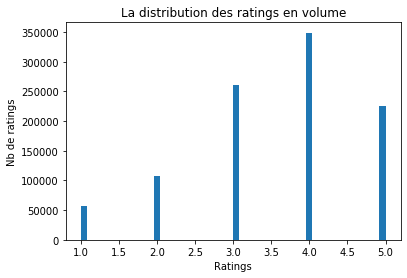

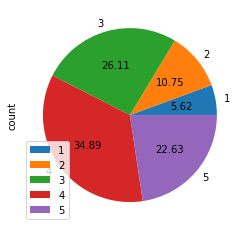

In [58]:
import matplotlib.pyplot as plt
ratings.rating.plot.hist(bins=50)
plt.xlabel("Ratings")
plt.ylabel("Nb de ratings")
plt.title("La distribution des ratings en volume")
rat = ratings.groupby('rating')['rating'].agg(['count'])
rat.plot.pie(y='count',fontsize=10,autopct='%.2f')

=> La majorité de ratings est 4 (34,89%), la minorité de ratings est 1 (5,62%)

<b> 3. Quelle est la distribution de l'âge des utilisateurs ?</b>

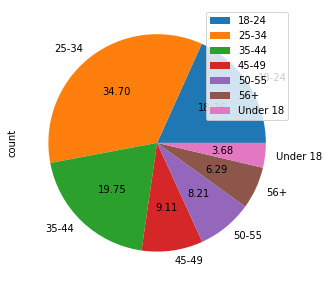

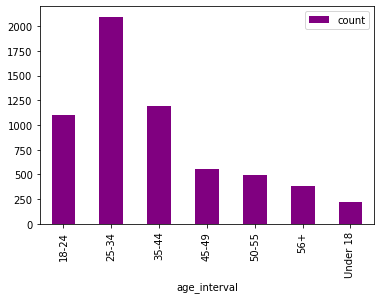

In [59]:
age_new = pd.merge(users,age_df)
age1 = age_new.groupby('age_interval')['age_interval'].agg(['count'])
age1.plot.pie(y='count',fontsize=10,autopct='%.2f',figsize=(5,5))
age1.plot.bar(y='count',color="purple")


=> La majorité des utilisateurs ont de 25 à 34 ans (34,70%) <br>
   La minorité des utilisateurs ont moins de 18 ans (3,68%)

<b> 4. Quelle est la distribution des métiers des utilisateurs ?</b>

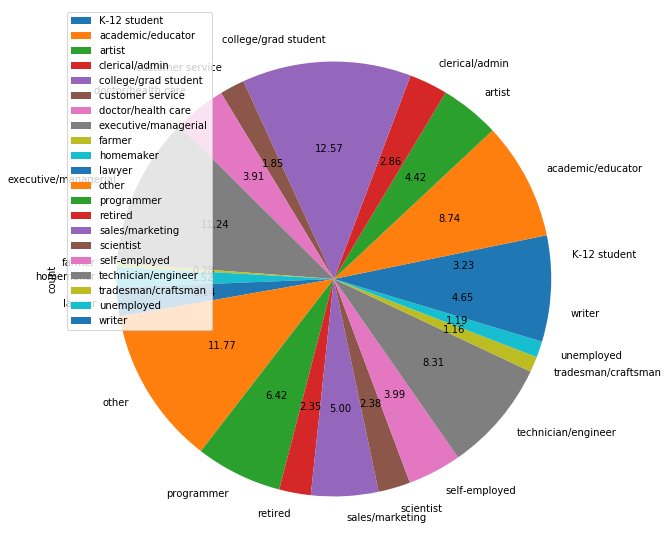

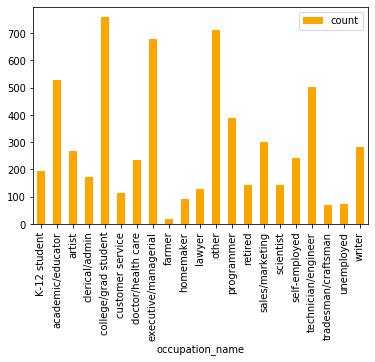

In [60]:
occup_new = pd.merge(users,occupation_df)
occup_new1 = occup_new.groupby('occupation_name')['occupation_name'].agg(['count'])
occup_new1.plot.pie(y='count',fontsize=10,autopct='%.2f',figsize=(10,10))
occup_new1.plot.bar(y='count',color="orange")

La distribution des métiers est : <br>
1ère place : les étudiants (12,57%), <br>
2ème place : les autres métiers (11,77%),<br>
3ème place : les cadres (11,24%), <br> 
Dernière place : les agriculteurs (0,28%).

 <b> 5. Quelle est la distribution des sexes ?</b>

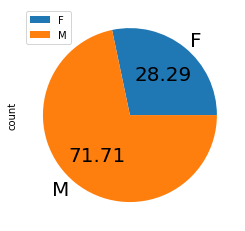

In [61]:
sexe = users.groupby('sex')['sex'].agg(['count'])
sexe.plot.pie(y='count',figsize=(8,4),fontsize=20,autopct='%.2f')


=> 71,71% d'hommes, 28,29% de femmes

<b> 6. Quels sont les genres de films les plus regardés par les utilisateurs ? </b>

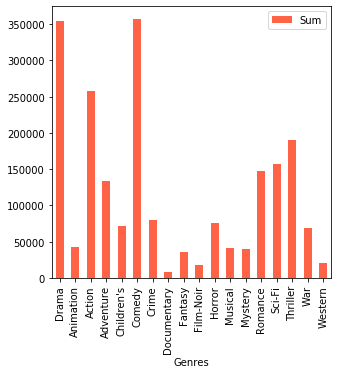

In [62]:
Count_genres = pd.Series.to_frame(genres.sum(axis=0))
Count_genres['Genres']=Count_genres.index
Count_genres.columns=["Sum","Genres"]
Count_genres.plot.bar(x="Genres",y="Sum",color="tomato",figsize=(5,5))

Les utilisateurs regardent beaucoup de films de genres : comedy, drama, action et thriller.
Les documentaires sont en dernière place.

<b> 7. Quels sont le nombre et la moyenne de ratings notés par sexe, par tranche d'âge et par métiers ? </b> 

<b> <i> 7.1. Ratings par sexe </i> </b>

In [63]:
rating_sexe = df3.groupby("sex")["rating"].agg(["size","mean"])
rating_sexe

,size,mean
sex,,
F,246440,3.620366
M,753769,3.568879


La moyenne de ratings des deux sexes est assez similaire (3,6).

<b> <i> 7.2. Ratings par tranche d'âge </i> </b>

In [64]:
rating_age_int=df3.groupby("age_interval")["rating"].agg(["size","mean"])
rating_age_int

,size,mean
age_interval,,
18-24,183536,3.507573
25-34,395556,3.545235
35-44,199003,3.618162
45-49,83633,3.638062
50-55,72490,3.714512
56+,38780,3.766632
Under 18,27211,3.549520


La moyenne de ratings par tranche d'âge est assez similaire (3,6).

<b> <i> 7.3. Ratings par métier</i> </b>

In [65]:
rating_metier_int=df3.groupby("occupation_name")["rating"].agg(["size","mean"])
rating_metier_int

,size,mean
occupation_name,,
K-12 student,23290,3.532675
academic/educator,85351,3.576642
artist,50068,3.573081
clerical/admin,31623,3.656516
college/grad student,131032,3.536793
customer service,21850,3.537529
doctor/health care,37205,3.661578
executive/managerial,105425,3.599772
farmer,2706,3.466741


La moyenne de ratings par métier est assez similaire (3,6).

<b> 8. Quel est le nombre de ratings et la moyenne de ratings par film ?</b>

In [66]:
film_ratings=df.groupby("title")["rating"].agg(["count","mean"]).sort_values(by="count",ascending = False)
film_ratings

,count,mean
title,,
American Beauty (1999),3428,4.317386
Star Wars: Episode IV - A New Hope (1977),2991,4.453694
Star Wars: Episode V - The Empire Strikes Back (1980),2990,4.292977
Star Wars: Episode VI - Return of the Jedi (1983),2883,4.022893
Jurassic Park (1993),2672,3.763847
Saving Private Ryan (1998),2653,4.337354
Terminator 2: Judgment Day (1991),2649,4.058513
"Matrix, The (1999)",2590,4.315830
Back to the Future (1985),2583,3.990321


Les 5 premiers films ont le nombre de ratings le plus important : <br>
1. American Beauty (1999),<br>
2. Star Wars: Episode IV - A New Hope (1977),<br>
3. Star Wars: Episode V - The Empire Strikes Back (1980),<br>
4. Star Wars: Episode VI - Return of the Jedi (1983),<br>
5. Jurassic Park (1993)

<b> 9. Densité du nombre de ratings en fonction des films </b> 

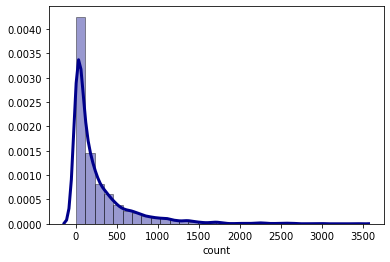

In [67]:
import seaborn as sns
sns.distplot(film_ratings['count'], hist=True, kde=True, 
             bins=30, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})

In [68]:
film_ratings.describe()

,count,mean
count,3706.000000,3706.000000
mean,269.889099,3.238892
std,384.047838,0.672925
min,1.000000,1.000000
25%,33.000000,2.822705
50%,123.500000,3.331546
75%,350.000000,3.740741
max,3428.000000,5.000000


 <span style="color:red"> <i>La plupart des films ont moins de 1000 ratings. La distribution de ratings est biaisée. </i> </span>

<b> 10. Quel est le nombre de ratings par genre de films en fonction du sexe  </b>
sachant que le nombre total de ratings : femme = 246440, homme = 753769 (réponse de 6.1) ?

In [69]:
genres_sexe = df3.groupby("sex")["Animation","Drama","Action","Adventure",
  "Children's", 'Comedy', 'Crime', 'Documentary', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
         'Thriller', 'War', 'Western'].agg(["sum"])
genres_sexe

,Animation,Drama,Action,Adventure,Children's,Comedy,Crime,Documentary,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
sex,,,,,,,,,,,,,,,,,,
F,12221,98153,45650,27332,21317,96271,16442,1940,8718,4202,14635,13505,9976,50297,27400,40308,14093,3477
M,31072,256376,211807,106621,50869,260309,63099,5970,27583,14059,61751,28028,30202,97226,129894,149372,54434,17206


Ici on s'apercoit que le nombre de ratings notés par les hommes est supérieur au nombre de ratings notés par les femmes. 
Cependant, le nombre d'hommes dans le total d'utilisateurs est beaucoup plus élevé que le nombre de femmes. Il faut donc calculer et interpréter les résultats en pourcentage. 

In [70]:
def hellosunny(total,lis1,lis2):
    for i in lis1:
        k=(i/total)*100
        lis2.append(k)


In [71]:
ensemble=[]
femme_per=[]
homme_per=[]
for i in genres_sexe.itertuples(index=False):
    for j in i:
        ensemble.append(j)
femme = ensemble[0:18]        
hellosunny(246440,femme,femme_per)
homme = ensemble[18:36]   
hellosunny(753769,homme,homme_per)


In [72]:
Genre_name=["Animation","Drama","Action","Adventure",
  "Children's", 'Comedy', 'Crime', 'Documentary', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
         'Thriller', 'War', 'Western']
sexe_genre_df={"Genres":Genre_name,"Per_number_rating_femme":femme_per,"Per_number_rating_homme":homme_per}
sexe_genre_df1 = pd.DataFrame(sexe_genre_df)
sexe_genre_df1

,Genres,Per_number_rating_femme,Per_number_rating_homme
0,Animation,4.959016,4.122218
1,Drama,39.828356,34.012542
2,Action,18.523779,28.099723
3,Adventure,11.090732,14.145050
4,Children's,8.649976,6.748619
5,Comedy,39.064681,34.534320
6,Crime,6.671807,8.371132
7,Documentary,0.787210,0.792020
8,Fantasy,3.537575,3.659344
9,Film-Noir,1.705080,1.865160


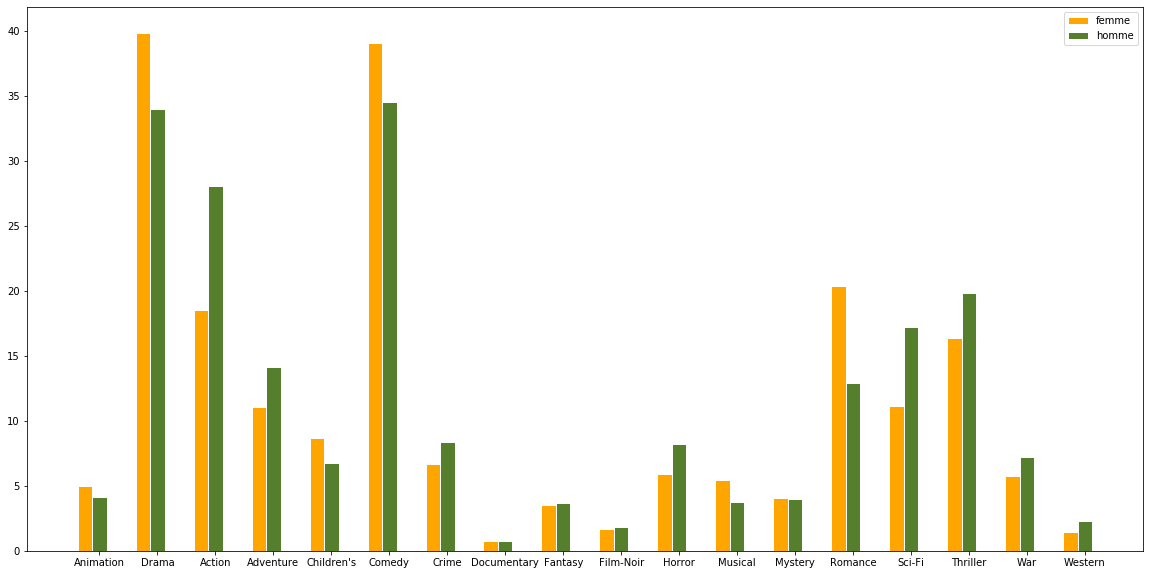

In [73]:
import numpy as np
import matplotlib.pyplot as plt
barWidth = 0.25

r1 = np.arange(len(femme_per))
r2 = [x + barWidth for x in r1]
plt.figure(figsize=(20,10))
plt.bar(r1, femme_per, color="orange", width=barWidth, edgecolor='white', label='femme')
plt.bar(r2, homme_per, color='#557f2d', width=barWidth, edgecolor='white', label='homme')
plt.xticks([r + barWidth for r in range(len(femme_per))], ["Animation","Drama","Action","Adventure",
  "Children's", 'Comedy', 'Crime', 'Documentary', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
         'Thriller', 'War', 'Western'])
plt.legend()
plt.show()




Les deux groupes de sexes ont beaucoup notés pour Comedy (Première place) <br>
Les femmes donnent plus de ratings par rapport aux hommes pour les genres : Drama, Romance, Animation, Children's <br>
Les hommes donnent plus de ratings par rapport aux femmes pour les genres : Action, Crime, Adventure, Horror, Sci-Fi, War, Thriller

<b> 11. Quels est le nombre de ratings par genre de films en fonction de la tranche d'âge ? </b> <br>
sachant que le nombre de ratings :<br>
18-24	183536<br>
25-34	395556<br>
35-44	199003<br>
45-49	83633<br>
50-55	72490<br>
56+	38780 <br>
Under 18	27211 (réponse de 6.2)

In [74]:
genres_age = df3.groupby("age_interval")["Animation","Drama","Action","Adventure",
  "Children's", 'Comedy', 'Crime', 'Documentary', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
         'Thriller', 'War', 'Western'].agg(["sum"])
genres_age

,Animation,Drama,Action,Adventure,Children's,Comedy,Crime,Documentary,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
age_interval,,,,,,,,,,,,,,,,,,
18-24,10269,58104,50186,26324,16924,69980,15373,1081,7875,2280,15184,7555,6401,25656,29033,35877,10874,2863
25-34,16454,138695,105678,52633,25743,143210,33030,3489,14290,6539,31235,14705,15160,58003,63156,77429,24830,7053
35-44,8117,71590,50503,26682,14004,69244,14895,1708,7006,4175,15122,8746,8179,29330,32333,36840,14514,4546
45-49,2889,32141,19357,10738,5400,27890,6048,687,2695,1860,6192,3898,3851,13283,13040,14933,6642,2133
50-55,2032,29247,17012,9090,3890,23133,5520,555,2127,1870,4681,3093,3520,11373,10674,13240,6314,2420
56+,1083,17269,8143,4488,1888,11961,2974,260,948,1207,1761,1889,2147,6279,4880,6537,3775,1333
Under 18,2449,7483,6578,3998,4337,11162,1701,130,1360,330,2211,1647,920,3599,4178,4824,1578,335


Interprétons en pourcentage

In [75]:
ensemble1=[]
lis1824_per=[]
lis2534_per=[]
lis3544_per=[]
lis4549_per=[]
lis5055_per=[]
lis56_per=[]
lisunder18_per = []
for i in genres_age.itertuples(index=False):
    for j in i:
        ensemble1.append(j)
lis1824 = ensemble1[0:18]  
lis2534 = ensemble1[18:36]
lis3544 = ensemble1[36:54]
lis4549 = ensemble1[54:72]
lis5055 = ensemble1[72:90]
lis56 = ensemble1[90:108]
lisunder18 = ensemble1[108:126]
hellosunny(183536,lis1824,lis1824_per)
hellosunny(395556,lis2534,lis2534_per)
hellosunny(199003,lis3544,lis3544_per)
hellosunny(83633,lis4549,lis4549_per)
hellosunny(72490,lis5055,lis5055_per)
hellosunny(38780,lis56,lis56_per)
hellosunny(27211,lisunder18,lisunder18_per)

In [76]:
age_genre_df={"Genres":Genre_name,"per_18-24":lis1824_per,"per_25-34":lis2534_per,"per_35-44":lis3544_per,
               "per_45-49":lis4549_per,"per_50-55":lis5055_per,"per56":lis56_per,"per_under18":lisunder18_per}
age_genre_df1 = pd.DataFrame(age_genre_df)
age_genre_df1

,Genres,per_18-24,per_25-34,per_35-44,per_45-49,per_50-55,per56,per_under18
0,Animation,5.595088,4.159714,4.078833,3.454378,2.803145,2.792677,9.000037
1,Drama,31.658094,35.063303,35.974332,38.431002,40.346255,44.530686,27.499908
2,Action,27.343954,26.716318,25.378009,23.145170,23.468065,20.997937,24.174047
3,Adventure,14.342690,13.306081,13.407838,12.839429,12.539661,11.572976,14.692588
4,Children's,9.221079,6.508054,7.037080,6.456781,5.366257,4.868489,15.938407
5,Comedy,38.128759,36.204735,34.795455,33.348080,31.911988,30.843218,41.020176
6,Crime,8.376013,8.350272,7.484812,7.231595,7.614843,7.668901,6.251148
7,Documentary,0.588985,0.882050,0.858279,0.821446,0.765623,0.670449,0.477748
8,Fantasy,4.290711,3.612636,3.520550,3.222412,2.934198,2.444559,4.997979
9,Film-Noir,1.242263,1.653116,2.097958,2.224002,2.579666,3.112429,1.212745


<i> Pour les genres de films : </i> <br>
Animation : beaucoup notés par les moins de 18 ans<br>
Drama : beaucoup notés par les plus de 56 ans<br>
Action, Adventure, Romance, Sci-Fi, Thriller : pas de différences entre les tranches d'âge<br>
Children : beaucoup notés par les moins de 18 ans<br>
Comedy : beaucoup notés par toutes les tranches d'âge<br>
Crime, Horror, Musical, Mystery, War : peu de ratings<br>
Documentary, Fantasy, Film-Noir, Western : très peu de ratings<br>

<b> 12. Quel est le nombre de ratings par genre de films en fonction des métiers ? </b>

In [77]:
genres_occup = df3.groupby("occupation_name")["Animation","Drama","Action","Adventure",
  "Children's", 'Comedy', 'Crime', 'Documentary', 'Fantasy',
 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
         'Thriller', 'War', 'Western'].agg(["sum"])
genres_occup

,Animation,Drama,Action,Adventure,Children's,Comedy,Crime,Documentary,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum,sum
occupation_name,,,,,,,,,,,,,,,,,,
K-12 student,2164,6000,6067,3726,3888,9465,1355,98,1275,235,1905,1410,732,2990,3932,4212,1385,300
academic/educator,3242,34769,18673,10215,5600,29949,6326,794,2763,1852,5079,3847,3730,14433,11795,14723,6006,1715
artist,2163,19273,11277,5986,3375,17982,3957,553,1760,1000,3676,2387,2026,7824,7110,8683,3072,973
clerical/admin,1321,11533,7078,3700,2226,11870,2469,285,1043,677,2210,1518,1356,5210,4022,5922,1950,659
college/grad student,7036,43546,35152,17910,11264,48672,10772,970,5225,1770,10383,5442,4740,18913,20352,25302,8205,2091
customer service,974,6369,6493,3228,1597,7908,1734,97,934,329,2390,888,718,2649,3789,4238,1348,546
doctor/health care,1565,14332,8601,4446,2596,13148,2800,302,1216,705,2576,1646,1469,5971,5146,6781,2572,717
executive/managerial,3451,38888,28863,14138,6251,35784,8738,707,3664,1865,7479,3881,4270,15453,16316,20654,7981,2695


<span style="color:red"> Les films de genres Drama et Comedy sont beaucoup regardés par tous les métiers. </span>

<b> 13. Quel est le nombre de ratings par utilisateur ? </b>

La distribution de note par utilisateurs: 
count    6040.000000
mean      165.597517
std       192.747029
min        20.000000
25%        44.000000
50%        96.000000
75%       208.000000
max      2314.000000
Name: rating, dtype: float64


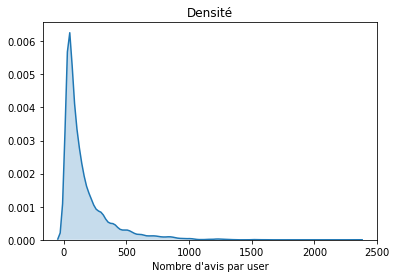

In [78]:
rating_user = df3.groupby("user_id")['rating'].count().sort_values()
print("La distribution de note par utilisateurs: ")

print(rating_user.describe())

#Un utilisateur évalue au moins 20 films
#Un utilisateur évalue au plus 2314 films

#Plot
sns.kdeplot(rating_user.values, shade=True)
plt.title("Densité")
plt.xlabel("Nombre d'avis par user")
plt.show()

<span style="color:red"> La distribution est biasée à gauche. La plupart des utilisateurs ont noté moins de 1000 ratings. </span>

# III. MODÉLISATION DU SYSTÈME DE RECOMMANDATION

# 1. POPULARITY MODEL

<b> Objectif </b> : <br>
Recommender les films les plus populaires et les mieux notés. <br>
<b> Description </b> : <br> 
Sur Youtube, Netflix, ou les journaux en ligne, nous observons toujours la section « les plus populaires en ce moment ». Il y a une forte chance que les vidéos, les articles ou les films apparaissent dans cette section nous intéressent. <br>
Cette recommandation n’est pas personnalisée. Tous les utilisateurs reçoivent les mêmes recommandations lorsqu’ils entrent sur ce site. 
Nous essayons de construire ce système de recommandation pour les films dans notre base de données en utilisant la formule « weighted rating » de IMDB. À noter qu’il existe aussi d’autres manières de calculer selon différents critères et formules. 
Le « weighted rating » est considéré comme le « score » de chaque film. Plus le score est élevé, plus le film est considéré comme populaire. 
 <br>
La méthode de calcul est celle de IMDB : 
<img src="WR.png" style="margin:auto" width="50%"/>
<span>&#8226;</span> a est le nombre de votes du film ; <br>
<span>&#8226;</span> min_v est le nombre de votes minimal pour rester dans la liste de recommandation ; <br>
<span>&#8226;</span> R est le rating moyen du film ; <br>
<span>&#8226;</span> C est le rating moyen de tous les films dans la base de données. <br>


<b> 1. Calcul de a et R : le nombre de votes et la moyenne de ratings pour chaque film </b>

In [79]:
film_ratings

,count,mean
title,,
American Beauty (1999),3428,4.317386
Star Wars: Episode IV - A New Hope (1977),2991,4.453694
Star Wars: Episode V - The Empire Strikes Back (1980),2990,4.292977
Star Wars: Episode VI - Return of the Jedi (1983),2883,4.022893
Jurassic Park (1993),2672,3.763847
Saving Private Ryan (1998),2653,4.337354
Terminator 2: Judgment Day (1991),2649,4.058513
"Matrix, The (1999)",2590,4.315830
Back to the Future (1985),2583,3.990321


<b> 2. Calcul de C : le rating moyen de tous les films </b>

In [80]:
C = film_ratings["mean"].mean()
C


3.238892177910892

Le rating moyen de tous les films est de 3,23.

<b> 3. Déterminer le minimum de votes pour entrer dans la liste recommandée </b>

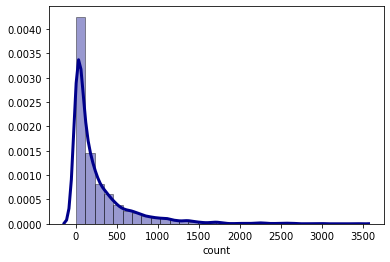

In [81]:
# 3.1. Densité du nombre de votes par films (c.f. 7.1)
dens_rat = sns.distplot(film_ratings['count'], hist=True, kde=True, 
             bins=30, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 3})
#=> distribution biasée


En regardant la densité de ratings, nous observons que la distribution est très biasée à gauche. Nous choisissons ensuite le seuil du nombre de ratings pour entrer dans la liste "les plus populaires" en précisant le quantile. <br>
Pour un quantitle de 80%, les films qui entrent dans la liste de recommandation doivent avoir un nombre de ratings supérieur à 80% de films dans le système.


In [74]:
# 3.2. Choisir quantile 80%. Pour entrer dans la liste, le film doit avoir le nombre de votes supérieur à 80% de films
min_v = film_ratings["count"].quantile(0.80)
min_v


429.0

<b> 4. Filtrer les films avec le nombre de votes qualifié </b>

Critère pour entrer dans la liste de recommandation : avoir un nombre de ratings supérieur à 429.

In [75]:
film_qualifie = film_ratings.copy().loc[film_ratings["count"] >= min_v]
x = film_qualifie["count"].count()
x


743

=> Il y a 743 films qualifiés.

<b> 5. Construire une fonction pour calculer le score des films </b>

In [76]:
def score(x, min_v=min_v, C=C):
    a = x['count']
    R = x['mean']
    return (a/(a+min_v) * R) + (min_v/(min_v+a) * C)    

ranking = [i for i in range(1, x+1)]



<b> 6. Calculer le score des films et afficher la liste de recommandation </b>

In [77]:
film_qualifie['score'] = film_qualifie.apply(score, axis=1)
film_quali_off=film_qualifie.sort_values(by="score",ascending=False)
film_quali_off["Name of movies"]=film_quali_off.index
s = pd.Series(ranking)
film_quali_rank = film_quali_off.set_index(s)
film_quali_rank["Ranking"]=film_quali_rank.index
film_quali_rank


,count,mean,score,Name of movies,Ranking
1,2227,4.554558,4.342050,"Shawshank Redemption, The (1994)",1
2,2223,4.524966,4.316925,"Godfather, The (1972)",2
3,2304,4.510417,4.310825,Schindler's List (1993),3
4,2991,4.453694,4.301311,Star Wars: Episode IV - A New Hope (1977),4
5,2514,4.477725,4.297141,Raiders of the Lost Ark (1981),5
6,1783,4.517106,4.269206,"Usual Suspects, The (1995)",6
7,2459,4.406263,4.232855,"Sixth Sense, The (1999)",7
8,3428,4.317386,4.197429,American Beauty (1999),8
9,2578,4.351823,4.193044,"Silence of the Lambs, The (1991)",9
10,2653,4.337354,4.184453,Saving Private Ryan (1998),10


<b> Conclusion : </b> <br>

<span>&#8226;</span> Il y a 743 films qualifiés pour entrer dans la liste de recommandation (bien noté + populaire) <br>
<span>&#8226;</span> 1ère place : Shawshank Redemption, The (1994) <br>
<span>&#8226;</span> 2ème place : Godfather, The (1972)...


<span style='color:#E9967A'> <b> Afficher top 250 IMDB : <b> </span>

In [78]:
film_rank_top_250=film_quali_rank[film_quali_rank['Ranking'] <=250]
film_rank_top_250



,count,mean,score,Name of movies,Ranking
1,2227,4.554558,4.342050,"Shawshank Redemption, The (1994)",1
2,2223,4.524966,4.316925,"Godfather, The (1972)",2
3,2304,4.510417,4.310825,Schindler's List (1993),3
4,2991,4.453694,4.301311,Star Wars: Episode IV - A New Hope (1977),4
5,2514,4.477725,4.297141,Raiders of the Lost Ark (1981),5
6,1783,4.517106,4.269206,"Usual Suspects, The (1995)",6
7,2459,4.406263,4.232855,"Sixth Sense, The (1999)",7
8,3428,4.317386,4.197429,American Beauty (1999),8
9,2578,4.351823,4.193044,"Silence of the Lambs, The (1991)",9
10,2653,4.337354,4.184453,Saving Private Ryan (1998),10


# 2. COLLABORATIVE FILTERING BY SVD - Surprise package

Nous allons créer notre système de recommandation par SVD grâce au package Surprise. <br> 
La décomposition en valeurs singulières de la matrice de données X, avec approximation de rang réduit m est : <br>

<span align="center" style="margin:auto; display:table;"> <b> X≈U⋅S⋅V <b>  </span>  <br>                                   
<span>&#8226;</span> X est une matrice m x n. <br>
<span>&#8226;</span> U est une matrice m x r orthogonale gauche singulière, qui représente la relation entre les utilisateurs et les facteurs latents.<br>
<span>&#8226;</span> S est une matrice diagonale r x r, qui décrit la force de chaque facteur latent et V est une matrice singulière droite diagonale r x n, qui indique la similarité entre les éléments et les facteurs latents. Les facteurs latents sont ici les caractéristiques des articles, par exemple, le genre du film.<br>
    
Chaque élément est représenté par un vecteur xi et chaque utilisateur est représenté par un vecteur yu. La note (le score) manquante pour l'utilisateur u est donnée comme suit : <br>
<br>
   
<img src="svd_1.png"
     width="20%"
     style="margin: auto;" /> <br>

<p> R ̂ui est une forme de factorisation dans la décomposition des valeurs singulières, xi et yu sont obtenus par :<p> <br>

<img src="svd_2.png"
     width="30%"
     style="margin: auto;" />

<br>

Afin de réduire l'erreur entre la valeur prédite par le modèle et la valeur réelle, l'algorithme utilise un terme de biais. Soit, pour une paire utilisateur-élément (u, i), μ est la note moyenne de tous les éléments, bi est la note moyenne de l'élément i moins μ et bu est la note moyenne donnée par l'utilisateur u moins μ, l'équation finale après avoir ajouté le terme de régularisation et le biais peut être donnée comme suit : <br>

<img src="svd_3.png"
     width="80%"
     style="margin: auto;" />


<span style = "color:red"> <b> Afin d'utiliser le package surprise, il faut installer : <b> </span> <br>
#conda install -c conda-forge scikit-surprise <br>
#conda update -n base -c defaults conda <br>

In [45]:
from surprise import Dataset, Reader, SVD, accuracy
from surprise.model_selection import train_test_split

<b> 1. Préparer les données (split data) </b>

In [46]:
# initiate a reader and read in our rating data
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df3[['user_id','movie_id','rating']], reader)

#split data 80-20
trainset, testset = train_test_split(data, test_size=.20)

<b> 2. Appliquer SVD algorithm </b>

In [47]:
#Appliquons SVD algorithm
algorithm = SVD()
algorithm.fit(trainset)

<b> 3. Prédire la note </b>

In [48]:
#Prédire la note
predictions = algorithm.test(testset)

<b> 4. Calculer RMSE </b>

<img src="rmse.png"
     alt="rmse" width="30%"
     style="margin:auto;" />
 <br>
Pour chaque individu u de l’échantillon test, nous essayons de prédire sa note pour l’item i à partir des notes des individus de la base d’apprentissage et de ses notes disponibles pour les autres items. K est l’ensemble des couples (utilisateur, item) pour lesquels la confrontation est effectuée.

In [49]:
#Calculer l'erreur
accuracy.rmse(predictions)

RMSE: 0.8755


0.8755369124371251

<b> 5. Comparer le score estimé et le score réel </b>

In [50]:
#Comparer le score estimé et le score réel
test = algorithm.test(testset)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)

#Renommer les colonnes
test.columns = ['user_id', 'movie_id', 'real_rating', 'predicted']

#Écart de note
test["diff"] = test['real_rating'] - test['predicted']

test.head()

,user_id,movie_id,real_rating,predicted,diff
0,6002,1544,3.0,3.348777,-0.348777
1,3751,1610,5.0,4.007111,0.992889
2,5333,3915,4.0,3.541301,0.458699
3,5138,2496,2.0,3.089483,-1.089483
4,4887,3760,3.0,3.216672,-0.216672


In [51]:
test['diff'].describe()

count    200042.000000
mean         -0.001816
std           0.875537
min          -4.000000
25%          -0.539916
50%           0.053536
75%           0.597334
max           4.000000
Name: diff, dtype: float64

<b> 6. Prédire le top 10 des films que l'utilisateur en question pourrait aimer </b>

In [52]:
matrice_user_film = test.pivot_table(index='user_id', columns='movie_id', values='predicted')
matrice_user_film

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,4.418081,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,4.063068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [53]:
#Prédire le top 10 des films que l'utilisateur en question pourrait aimer:

def predictions(user_id):
    film_recommande = pd.DataFrame(matrice_user_film.loc[user_id])
    film_recommande.columns = ["predicted_rating"]
    film_recommande  = film_recommande.sort_values('predicted_rating', ascending=False)    
    film_recommande  = film_recommande.head(10)
    #a = film_recommande.index.tolist()
    #b = film_recommande['predicted_rating'].values.tolist()
    return film_recommande.merge(movies, how ='inner', on = 'movie_id')


In [54]:
user_id = int(input("Entrez l'identifiant à qui vous voulez recommander des films: "))
predictions(user_id)

Entrez l'identifiant à qui vous voulez recommander des films: 1


,movie_id,predicted_rating,title,genre
0,914,4.696407,My Fair Lady (1964),Musical|Romance
1,1545,4.411139,Ponette (1996),Drama
2,1197,4.400005,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance
3,2797,4.395910,Big (1988),Comedy|Fantasy
4,2918,4.344272,Ferris Bueller's Day Off (1986),Comedy
5,2018,4.300783,Bambi (1942),Animation|Children's
6,1029,3.940785,Dumbo (1941),Animation|Children's|Musical
7,661,3.636121,James and the Giant Peach (1996),Animation|Children's|Musical
8,1,NaN,Toy Story (1995),Animation|Children's|Comedy
9,2,NaN,Jumanji (1995),Adventure|Children's|Fantasy


In [55]:
def predictions_bis(user_id):
    film_recommande = pd.DataFrame(matrice_user_film.loc[user_id])
    film_recommande.columns = ["predicted_rating"]
    film_recommande  = film_recommande.sort_values('predicted_rating', ascending=False)    
    film_recommande  = film_recommande.head(10)
    #a = film_recommande.index.tolist()
    #b = film_recommande['predicted_rating'].values.tolist()
    return film_recommande.index.tolist()


In [56]:
#Format test data
test_bis = test.copy().groupby('user_id')['movie_id'].agg({'vu': (lambda x: list(set(x)))})

#Recommandation pour chaque utilisateur
resultat = [] 
for user in test_bis.index:
    cf_predictions = predictions_bis(user) #pour chaque user dans index, executer la fonction predictions_bis
    resultat.append(cf_predictions)
        
test_bis['pred'] = resultat
test_bis.head()

C:\Users\lytru\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  


,vu,pred
user_id,,
1,"[2018, 1029, 2918, 1545, 2797, 1197, 914, 661]","[914, 1545, 1197, 2797, 2918, 2018, 1029, 661,..."
2,"[902, 2571, 3468, 3471, 2321, 3735, 1687, 1945...","[1207, 2501, 1246, 1945, 3468, 2571, 3471, 178..."
3,"[1378, 552, 1641, 3534, 1198, 1394, 2997, 2617...","[1198, 1641, 1394, 1378, 2997, 2617, 552, 3868..."
4,"[1954, 2692, 1214]","[1214, 1954, 2692, 1, 2, 3, 4, 5, 6, 7]"
5,"[1921, 1923, 2188, 2318, 272, 1171, 1684, 1046...","[29, 1719, 1171, 866, 2318, 1635, 32, 1921, 28..."


Nous obtenons une DataFrame qui se compose de tous les films vus dans test set et le top 10 des films suggérés à chaque utilisateur selon l'algorithme SVD.

# 3. COLLABORATIVE FILTERING: Memory-based by User-User Neighbor (N Nearest Neighbors)

<img src="user_1.png"
     alt="User-User" width="80%"
     style="margin:auto;" />


<b> Principe </b> : les meilleures recommandations proviennent des individus qui présentent des goûts ou comportements similaires. <br>

L'objectif est de recommander des films aux utilisateurs et chercher à prédire l'« avis » donné par l'utilisateur.

<b>La fonction du score : </b>
<img src="user_2.png"
     alt="Score"
     style="margin:auto;" />

<b>Méthodologie :</b> <br> 

1. 1ère étape : Un individu u exprime ses préférences par un système de notation. <br> 
2. 2ème étape : Le système recherche les utilisateurs qui présentent un « profil » le plus proche (en termes de préférences). <br>
3. 3ème étape :  À partir de ce voisinage, les notes pour chaque film, non évalué par u, sont calculées. Lui sont alors recommandés les films pour lesquels une note élevée est prédite. <br>

En réalité, les gens évaluent souvent les films sur des échelles très différentes. Certains utilisateurs ayant des critères très hauts (par exemple les acteurs, les réalisateurs, etc) donnent à leurs films préférés un avis 3/5. Mais certains étant plus "souples" donnent à leurs films préférés par exemple un avis 4/5. Donc, pour augmenter l’efficacité de notre modèle, nous normalisations notre base de données. Nous allons calculer s(u,i) : le rating moyen que l'utilisateur donne à chaque film plus un écart (le biais des préférences). Cet écart est la différence entre le rating réel et le rating moyen du film. 


In [61]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

<b>1. Créer la matrice users-item </b>

In [59]:
#Split data 

df_copy = df.copy()
train_set = df_copy.sample(frac =0.8, random_state=42)
test_set = df_copy.drop(train_set.index)

print("Train set : " + str(train_set.shape))
print("Test set :  " + str(test_set.shape))

Train set : (800167, 10)
Test set :  (200042, 10)


Le biais des préférences associées aux utilisateurs pose un problème. Certains utilisateurs ont tendance à toujours donner des ratings élevés ou faibles à tous les films. Nous pouvons imaginer que la différence relative des ratings donnés par les utilisateurs est plus importante que les valeurs absolues des ratings. 

In [62]:
#Calculer le rating moyen de chaque abonné
moy = train_set.groupby(by="user_id",as_index= False)['rating'].mean()

#Fusionner avec la base ratings pour avoir plus d'info sur les ratings
rating_moy = pd.merge(train_set,moy, on = 'user_id')

#Pour connaître la marge de rating par rapport au rating moyen 
rating_moy["dev_rating"]=rating_moy['rating_x']-rating_moy['rating_y']

#rating_moy.head()
rating_moy = rating_moy.drop(columns =["genre","age","sex","occupation","zip_code","title"])

rating_moy

,movie_id,user_id,rating_x,unix_timestamp,rating_y,dev_rating
0,588,510,5,976207924,3.800000,1.200000
1,2294,510,4,976207891,3.800000,0.200000
2,480,510,4,976207500,3.800000,0.200000
3,442,510,4,976207547,3.800000,0.200000
4,1805,510,5,976206428,3.800000,1.200000
5,2720,510,5,976205875,3.800000,1.200000
6,1064,510,4,976208089,3.800000,0.200000
7,2105,510,5,976207527,3.800000,1.200000
8,364,510,5,976207904,3.800000,1.200000
9,3471,510,3,976206475,3.800000,-0.800000


Nous construisons ensuite la matrice user-movie. Au lieu de mettre le rating absolu des utilisateurs (ie 1 2 3 4 5), nous mettons le biais des préférences (la variable : dev_rating). L'étape suivante est de trouver les utilisateurs similaires. Pour cela, nous remplaçons les valeurs manquantes dans la matrice user-movie par les écarts de préférence.

In [63]:
#User-item matrice 

user_film = pd.pivot_table(rating_moy, values ='dev_rating', index='user_id',columns ='movie_id')
user_film.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.790698,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,-1.10625,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [64]:
#Remplacer les valeurs manquantes par le biais du rating moyenne du film 
user_film_fin =user_film.fillna(user_film.mean(axis=0)) # mean(axis=0): la moyenne de toutes les lignes de chaque colonne
user_film_fin.head()


movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.790698,-0.289718,-0.45612,-0.686021,-0.41321,0.279559,-0.113135,-0.47615,-0.656421,-0.012295,...,-0.541852,-0.824223,-1.870005,-1.283824,-0.114154,0.029388,0.542386,0.076002,0.33381,0.184672
2,0.477113,-0.289718,-0.45612,-0.686021,-0.41321,0.279559,-0.113135,-0.47615,-0.656421,-0.012295,...,-0.541852,-0.824223,-1.870005,-1.283824,-0.114154,0.029388,0.542386,0.076002,0.33381,0.184672
3,0.477113,-0.289718,-0.45612,-0.686021,-0.41321,0.279559,-0.113135,-0.47615,-0.656421,-0.012295,...,-0.541852,-0.824223,-1.870005,-1.283824,-0.114154,0.029388,0.542386,0.076002,0.33381,0.184672
4,0.477113,-0.289718,-0.45612,-0.686021,-0.41321,0.279559,-0.113135,-0.47615,-0.656421,-0.012295,...,-0.541852,-0.824223,-1.870005,-1.283824,-0.114154,0.029388,0.542386,0.076002,0.33381,0.184672
5,0.477113,-0.289718,-0.45612,-0.686021,-0.41321,-1.106250,-0.113135,-0.47615,-0.656421,-0.012295,...,-0.541852,-0.824223,-1.870005,-1.283824,-0.114154,0.029388,0.542386,0.076002,0.33381,0.184672


<b> 2. Chercher des utilisateurs similaires </b>

<b> 2.1. Filtrage Collaboratif en utilisant la distance euclidienne </b>

Tout d'abord, nous utilisons la distance euclidienne pour trouver le TOP 50 des utilisateurs simliaires. La "Distance Euclidienne" est la méthode la plus simple pour calculer le score de similitude. Plus la distance entre deux utilisateurs est petite, plus ils se ressemblent. <br>

<b>Idée</b> : Nous créons la matrice User-User dont le score de similitude est calculé par la distance euclidienne. Ensuite, nous ordonnons le score par ordre croissante et obtenons le TOP 50 des utilisateurs similaires.

In [65]:
#Construisons la matrice user-user en utilisant la distance euclidienne
from sklearn.metrics.pairwise import pairwise_distances

user_user_euclidean = pairwise_distances(user_film_fin, metric = 'euclidean')
smlr_euclidean = pd.DataFrame(user_user_euclidean, index=user_film_fin.index)
smlr_euclidean.columns =user_film_fin.index
smlr_euclidean.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,10.324975,7.846745,7.083126,14.142390,7.943971,6.634721,9.726697,8.386421,16.839160,...,11.318595,10.418215,7.972128,6.260166,19.555524,22.427676,12.265058,7.039465,8.914399,17.276152
2,10.324975,0.000000,10.410112,10.207226,16.342171,10.630004,9.765917,12.386582,11.349542,18.436843,...,13.509741,12.614279,10.737207,9.454058,20.594294,22.939034,13.855003,10.104237,11.479750,19.054916
3,7.846745,10.410112,0.000001,6.977872,14.285510,8.188484,6.705985,9.917725,8.981077,17.024534,...,11.612128,10.823054,8.256493,6.412940,19.863951,22.178388,12.276628,7.108930,8.961887,17.461877
4,7.083126,10.207226,6.977872,0.000000,13.880450,7.300448,5.919602,9.102751,8.270723,16.685490,...,11.187550,10.088504,7.317044,5.515703,19.457992,22.036555,11.881467,6.338523,8.658374,16.828245
5,14.142390,16.342171,14.285510,13.880450,0.000000,14.513272,13.311279,15.293158,15.293227,20.906263,...,16.435306,15.969305,14.431881,13.484312,22.650140,25.062572,17.405614,13.917970,15.012346,20.953785


In [66]:
def neighbours_smlr_euclidienne(df,n):
    order = np.argsort(df.values, axis=1)[:,:n] #Retourne les indices qui permettent de trier la df en fonction de sa valeur 
                                                #par ordre décroissant.  
                                                #axe =1: l'odre décroissant de toutes les colonnes de chaque ligne

    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=True).iloc[:n].index,#je veux une ordre décroissant
                                      #pour trouver les utilisateurs les plus similaires
                                     index = ['rang{}'.format(i) for i in range(1,n+1)]),axis=1) #nommer l'indice
    return df

In [67]:
#Top 50 des utilisateurs les plus similaires par la distance euclidienne
smlr_top50_euclidean = neighbours_smlr_euclidienne(smlr_euclidean,50)
smlr_top50_euclidean.head()

,rang1,rang2,rang3,rang4,rang5,rang6,rang7,rang8,rang9,rang10,...,rang41,rang42,rang43,rang44,rang45,rang46,rang47,rang48,rang49,rang50
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,5007,2923,5168,277,2363,5069,3461,592,4881,...,2440,4100,5215,4413,790,298,2834,2345,3730,2467
2,2,2834,1669,2111,277,2292,3743,2268,5007,4749,...,4259,2128,250,4254,3739,447,3303,2538,2440,1801
3,3,3743,5168,1801,2111,1674,4010,4537,277,2268,...,1187,2061,5309,4741,2538,2759,171,4159,3303,298
4,4,446,5168,4230,2729,2336,4176,2252,3828,5876,...,3739,2184,455,124,298,4881,4010,1351,383,171
5,5,5694,1844,276,1763,277,2379,4189,5304,782,...,5266,383,5073,3421,7,942,1622,427,5696,598


Nous pouvons ignorer le "rang1" car la distance de l’utilisateur et lui-même est 0. Par la distance euclidienne, l’utilisateur 5007 ressemble le plus à l’utilisateur 1, l’utilisateur 2834 ressemble le plus à l’utilisateur 2, etc. 

<b> 2.2. Filtrage Collaboratif en utilisant la similarité cosinus </b>

La similarité cosinus (cosine_similarity) est plus complexe que la distance euclidienne. Cependant, cette méthode tend à donner un résultat plus fiable que la méthode euclidienne pour la base de données non normalisée, où certains utilisateurs ont tendance à toujours donner des notes élevées ou faibles à tous les films. <br> 

Plus la valeur de similarité cosinus est proche de 1, plus les utilisateurs sont similaires ; inversement, plus la valeur de similarité cosinus est proche de 0, plus les utilisateurs sont différents. 

<b> Idée </b> : Nous créons la matrice User-User dont le score de similitude est calculé par la similarité cosinus. Ensuite, nous ordonnons les scores par ordre décroissant et obtenons le TOP 50 des utilisateurs similaires.


In [68]:
#La matrice User-User par la similarité cosinus 
user_user = cosine_similarity(user_film_fin) #calculer la similarité par la similarité cosinus
np.fill_diagonal(user_user,0)
smlr = pd.DataFrame(user_user,index=user_film_fin.index) #prendre l'indice de la matrice user_film comme indice
smlr.columns =user_film_fin.index # les colonnes sont également user_id
smlr.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.964404,0.978935,0.982772,0.935991,0.978409,0.984859,0.968179,0.976128,0.909007,...,0.957322,0.963862,0.978250,0.986507,0.890788,0.869229,0.949937,0.982979,0.972938,0.911365
2,0.964404,0.000000,0.963887,0.965237,0.915120,0.962338,0.968180,0.949313,0.957215,0.892146,...,0.940127,0.947777,0.961567,0.970189,0.878480,0.862265,0.937118,0.965936,0.956158,0.891788
3,0.978935,0.963887,0.000000,0.983363,0.934744,0.977156,0.984616,0.966996,0.972703,0.907164,...,0.955171,0.961057,0.976770,0.985924,0.887088,0.872313,0.949968,0.982729,0.972749,0.909355
4,0.982772,0.965237,0.983363,0.000000,0.938407,0.981788,0.987966,0.972167,0.976803,0.910743,...,0.958338,0.966147,0.981701,0.989544,0.891940,0.874217,0.953073,0.986220,0.974499,0.916127
5,0.935991,0.915120,0.934744,0.938407,0.000000,0.932611,0.943444,0.925504,0.925247,0.864682,...,0.914276,0.919064,0.933373,0.941922,0.853922,0.834559,0.903909,0.938064,0.927929,0.870701


In [69]:
def neighbours_smlr(df,n):
    order = np.argsort(df.values, axis=1)[:,:n] #Retourne les indices qui permettraient de trier la df en fonction de sa valeur 
                                                #par ordre décroissante.  
                                                #axe =1: l'odre décroissante de toutes les colonnes de chaque ligne

    df = df.apply(lambda x: pd.Series(x.sort_values(ascending=False).iloc[:n].index,#je veux une ordre décroissante
                                      #pour trouver les utilisateurs les plus similaires
                                     index = ['rang{}'.format(i) for i in range(1,n+1)]),axis=1) #nommer l'indice
    return df

In [70]:
#Top 50 des utilisateurs les plus similaires 
smlr_top50 = neighbours_smlr(smlr,50)
smlr_top50.head()

,rang1,rang2,rang3,rang4,rang5,rang6,rang7,rang8,rang9,rang10,...,rang41,rang42,rang43,rang44,rang45,rang46,rang47,rang48,rang49,rang50
user_id,,,,,,,,,,,,,,,,,,,,,
1,5007,2923,5168,277,2363,592,3461,5069,4881,1801,...,4100,5215,4413,298,790,2345,2834,3730,2467,4019
2,2834,1669,2111,277,2292,3743,2268,5007,4749,5918,...,2128,250,4254,3739,447,3303,2538,4752,2440,1801
3,3743,5168,1801,2111,1674,4010,4537,277,2268,4749,...,5309,2061,4741,2538,2759,171,4159,3303,298,2729
4,446,5168,4230,2729,2336,4176,2252,3828,5876,5936,...,3739,2184,298,124,4881,4010,1351,383,171,1708
5,5694,1844,276,1763,277,2379,4189,5304,782,5007,...,383,5073,7,942,3421,3899,1622,598,427,5696


Par la similarité cosinus, l’utilisateur 5007 ressemble le plus à l’utilisateur 1, l’utilisateur 2834 ressemble le plus à l’utilisateur 2, etc. 

<b>3. Commentaires </b>

Nous constatons que les deux méthodes nous donnent le même résultat du TOP 50 des utilisateurs similaires. 
Donc, nous décidons de choisir la similarité cosinus.

<b>3.1. Comparer le rating </b>

Nous voulons évaluer le modèle en utilisant la similarité cosinus. Pour cela, nous cherchons les films communs entre deux utilisateurs, puis regardons l’écart de ratings entre notre modèle et la réalité de ces films. Si l’écart n’est pas grand, notre méthode de similarité est pertinente. <br> <br>
Par exemple, nous voulons tester la similarité entre l’utilisateur 1 et l’utilisateur 2923. Pour le film numéro 1270, l’utilisateur 1 donne une note de 4 et l’utilisateur 2923 donne une note de 5, soit une différence de 1. Par contre, pour les films numéro 2918 et numéro 1197, les deux utilisateurs donnent la même note. <br> <br>
Nous pouvons conclure que notre méthode de similarité cosinus marche bien.  


In [72]:
#Pour savoir si la similarité marche, cad tester si les utilisateurs sont similaires ou pas

def smlr_film(user1,user2):
    film_commun = pd.merge(rating_moy[rating_moy.user_id==user1], rating_moy[rating_moy.user_id==user2], 
                                                                            on = "movie_id",
                                                                           how="inner")
    #Trouver les film communs pour comparer les évaluations des utilisateurs
    return film_commun

In [73]:
a = int(input("Entrez l'identifiant de l'utilisateur 1: "))
b = int(input("Entrez l'identifiant de l'utilisateur 2: "))
c = smlr_film(a,b)
c = c.loc[:, ['rating_x_x','rating_x_y',"movie_id"]] 
#rating_x_x => le rating du 1er utilisateur
#rating_x_y => le rating du 2ème utilisateur
c["diff"] = c['rating_x_x']- c['rating_x_y']
#diff : l'écart de rating entre 2 utilisateurs
c
#Entre eux, y a 6 films en commun et l'écart de rating n'est pas grand

Entrez l'identifiant de l'utilisateur 1: 1
Entrez l'identifiant de l'utilisateur 2: 2923


,rating_x_x,rating_x_y,movie_id,diff
0,5,4,1270,1
1,4,4,2918,0
2,3,3,1197,0


<b> 3.2. Estimer les scores </b>


Dans un deuxième temps, nous calculons le score espéré (la note espérée) que pourrait donner un utilisateur.

In [74]:
def user_film_score(user,item):
    a1 = smlr_top50[smlr_top50.index==user].values #créer 1 array des utilisateurs similaires à l'utilisateur donné
    b = a1.squeeze().tolist() #liste des utilisateurs
    c = user_film_fin.loc[:,item] #prend tous les bias du ratings du film donée (item)
    d = c[c.index.isin(b)] #Prend les user_id qui sont dans la liste b et leur biais du rating du film donné
    f = d[d.notnull()] #Prend les user_id qui sont dans la liste b dont le bias du rating est non nul
    avg_user = moy.loc[moy['user_id']==user, 'rating'].values[0] #Calculer le rating moyen de l'utilisateur donné
    index = f.index.values.squeeze().tolist() #liste de user_id (user_id = index)
    corr = smlr.loc[user,index] #la corrélation entre l'utilisateur donné et les autres utilisateurs
    fin = pd.concat([f,corr],axis=1)
    fin.columns =['adg_score','correlation']
    fin['score'] = fin.apply(lambda x: x['adg_score']* x['correlation'],axis=1)
    numerateur = fin['score'].sum()
    denominateur = fin['correlation'].sum()
    score_final = avg_user + (numerateur/denominateur)
    return score_final

In [75]:
#Comparer la note espérée
user = int(input("Entrez l'identifiant de l'utilisateur: "))
film = int(input("Entrez l'identifiant du film: "))
print(" ")
print("score (%d,%d) = " %(user,film),user_film_score(user,film))

Entrez l'identifiant de l'utilisateur: 1
Entrez l'identifiant du film: 3
 
score (1,3) =  3.7531819109258855


Par exemple, nous voulons calculer la rating que l’utilisateur 1 donnerait au film ayant l’identifiant n°3. D’après notre modèle, la note espérée est d’environ 4.

<b>4. Recommander des films </b>

<b> Objet </b>: Création d'un système qui recommande le TOP 10 des films pour l'utilisateur en question.

<b> Idée </b> : Nous créons d'abord une liste contenant tous les films déjà vus par l'utilisateur en question. Puis nous créons une liste des utilisateurs qui lui ressemblent avec les films qu'ils ont déjà vus. Nous faisons ensuite une liste des films que l'utilisateur en question n'a jamais vus. Enfin, nous calculons le score des films, autrement dit le rating espéré donné par l'utilisateur en question, et ordonnons ces scores en ordre décroissant pour avoir le TOP 10 des films recommandés.  

In [76]:
#Pré-traitement: Faisons d'abord la requête pour savoir qui regarde quoi. 
rating_moy = rating_moy.astype({"movie_id":str})
movie_user = rating_moy.groupby(by ="user_id")['movie_id'].apply(lambda x: ','.join(x))
movie_user

user_id
1       1836,914,1,1028,2692,3186,745,2028,594,3408,10...
2       3255,2268,2717,1537,1442,110,593,1096,1225,121...
3       590,1197,3868,260,1266,3421,2871,3168,1259,552...
4       2947,2692,1097,480,260,3702,1201,1196,1198,341...
5       16,3105,2762,509,1721,2734,1885,3051,2323,3113...
6       1088,2802,3717,364,1,1035,1028,383,3565,17,201...
7       442,589,3256,1580,3107,1573,2916,733,377,349,1...
8       1466,266,2692,2702,1682,150,16,562,510,476,268...
9       412,1500,3298,1446,318,3301,1307,3755,1221,527...
10      595,2946,3194,110,745,316,3591,1411,1441,2096,...
11      2282,1461,440,356,2076,593,342,1546,586,1573,1...
12      111,923,1252,934,999,593,1303,1641,1247,2616,1...
13      1259,110,736,1287,552,3036,2028,21,1580,2640,1...
14      296,2396,2731,3578,2572,2858,3033,3354,2762,26...
15      3773,3723,2841,1500,1343,1617,1291,2724,2321,5...
16      2568,2355,2699,1682,2723,2629,2555,2987,2572,2...
17      3070,162,30,1196,2377,1284,741,2752,3702,529,1...
18    

Fonction de recommandation

In [77]:
def recommender (user):
    #Créer une liste des films recommandés (vus par les utilisateurs similaires mais jamais vu par l'utilisateur en question)
    
    film_vu = user_film.columns[user_film[user_film.index == user].notna().any()].tolist() #une liste des films déjà vu par l'utiisateur donné
    a1 = smlr_top50[smlr_top50.index==user].values #créer 1 array des utilisateurs similaires à l'utilisateur donné
    b = a1.squeeze().tolist() #liste des utilisateurs
    d = movie_user[movie_user.index.isin(b)] #Une liste des utilisateurs similaires à l'utilisateur donné ainsi que leurs films
    l = ','.join(d.values) 
    movie_sim =l.split(',') #créer une liste de tous les films similaires
    movie_recom = list(set(movie_sim)-set(list(map(str,film_vu))))
    movie_recom = list(map(int,movie_recom)) # créer une liste des films recommandés à l'utilisateur donné
    score =[]
    
    #Calculer le score espéré
    for item in movie_recom:
        c = user_film_fin.loc[:,item]
        d_2 = c[c.index.isin(b)]
        f = d_2[d.notnull()] #Prend les user_id qui sont dans la liste b sont le rating est non nul
        avg_user = moy.loc[moy['user_id']==user, 'rating'].values[0] #Calculer le rating moyen de l'utilisateur donné
        index = f.index.values.squeeze().tolist() #liste de user_id (user_id = index)
        corr = smlr.loc[user,index] #la corrélation entre l'utilisateur donné et les autres utilisateurs
        fin = pd.concat([f,corr],axis=1)
        fin.columns =['adg_score','correlation']
        fin['score'] = fin.apply(lambda x: x['adg_score']* x['correlation'],axis=1)
        numerateur = fin['score'].sum()
        denominateur = fin['correlation'].sum()
        score_final = avg_user + (numerateur/denominateur) 
        score.append(score_final)
        
    #Créer le top 10 films recommandés 
    data = pd.DataFrame({'movie_id':movie_recom,'score':score}) #le tableau contient l'identifiant des films et leur score
    top10 = data.sort_values(by='score',ascending = False).head(10) #Top10 films en ordre décroissante du score
    movie_name = top10.merge(movies,how='inner',on ='movie_id')
    #temp3 = movie_name.title.values.tolist()
    #temp4 = movie_name.score.values.tolist()
    #movie_score = pd.DataFrame(list(zip(temp3,temp4)), columns = ['Title','Score'])
    movie_names =movie_name[['title','score']].values.tolist()
    #temp3 = pd.DataFrame(movie_names,index = [1:10], columns=['Title','score'],dtype ='float')
    return movie_names


In [79]:
user = int(input("Entrez l'identifiant (user_id) à qui vous voulez recommander des films: "))
predicted_movies = recommender(user)
print(" ")
print("Les utilisateurs qui sont similaires à vous, ont aimé aussi :")
print(" ")
for i in predicted_movies:
    print(i)

Entrez l'identifiant (user_id) à qui vous voulez recommander des films: 1
 
Les utilisateurs qui sont similaires à vous, ont aimé aussi :
 
['Shawshank Redemption, The (1994)', 5.037601060448533]
['Usual Suspects, The (1995)', 5.0142287470136155]
['Godfather, The (1972)', 5.000186614107748]
['Wrong Trousers, The (1993)', 4.962812115305134]
['Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1963)', 4.957832816941282]
['Raiders of the Lost Ark (1981)', 4.942734345480739]
['Voyage to the Beginning of the World (1997)', 4.942635658914729]
['Rear Window (1954)', 4.9330764154865046]
['Sunset Blvd. (a.k.a. Sunset Boulevard) (1950)', 4.926497046095704]
['Star Wars: Episode IV - A New Hope (1977)', 4.92155518323799]


<b>5. Évaluation du modèle </b>

Nous comparons la rating calculé de notre méthode avec le rating dans la base de test pour déterminer les écarts. Si les écarts entre la note réelle et la note espérée est grande, le modèle n'est pas pertinent.

Nous écrivons une fonction qui permet de trouver les films et les ratings donnés par l’utilisateur qui nous intéresse dans la base de test.<br>
Nous choisissons l'utilisateur 1 pour l'évaluation. <br>

Dans la base de test, l’utilisateur 1 donne au film numéro 260 un rating de 4, etc.


In [80]:
def score(user):
    user_score_test= test_set.loc[test_set['user_id']==user,:]
    user_score_test_bis= user_score_test.groupby('movie_id')['rating'].agg(np.mean)
    return print(user_score_test_bis)
#Abis = np.unique(temp10)
#Abis
aa = int(input("Entrez l'identifiant de l'utilisateur: "))
score = score(aa)

Entrez l'identifiant de l'utilisateur: 1
movie_id
260     4
531     4
595     5
783     4
919     4
1097    4
1246    4
1287    5
2294    4
2687    3
Name: rating, dtype: int64


Puis nous écrivons une fonction qui nous permet de calculer le rating espéré que donnerait l’utilisateur pour ces films. 
En utilisant les données dans la base de train, l’utilisateur 1 pourrait donner au film numéro 260 une note d’environ 5. 


In [81]:
def comparaison(user):
    user_test= test_set.loc[test_set['user_id']==user,:]
    temp_user_test = user_test.copy().groupby('movie_id')['rating'].agg(np.mean)
    for i in temp_user_test.index:
        score = user_film_score(user,i).tolist()
        print("score espéré (%d,%d) = " %(user,i),score)


In [82]:
user =int(input("Entrez l'identifiant de l'utilisateur: "))
comparaison = comparaison(user)

Entrez l'identifiant de l'utilisateur: 1
score espéré (1,260) =  4.92155518323799
score espéré (1,531) =  4.394240142535589
score espéré (1,595) =  4.475107191156776
score espéré (1,783) =  3.8684061959754388
score espéré (1,919) =  4.738383457236204
score espéré (1,1097) =  4.466237010775847
score espéré (1,1246) =  4.600645686879972
score espéré (1,1287) =  4.6434602075235425
score espéré (1,2294) =  4.111297097593883
score espéré (1,2687) =  4.276911573400159


<b>6. Limites de la méthode "Filtrage Collaboratif user-user" </b>

<b> A. Problème de "cold start" </b> <br>
L'un des inconvénients de Filtrage Collaboratif est que cette approche est basée sur l'historique des préférences des utilisateurs. Cela pose des problèmes pour les nouveaux films (ou encore les films n'ayant pas beaucoup d'évaluations). Lorsque de nouveaux films sont ajoutés au système, ils doivent être évalués par un nombre important d'utilisateurs avant de pouvoir être recommandés aux utilisateurs qui ont des goûts similaires à ceux qui les ont évalués. De plus, les préférences des utilisateurs changent très souvent. 

<b> Idée </b> : Nous créons une DataFrame contenant des films vus et suggérés en fonction des utilisateurs. Puis nous effectuons une requête pour connaître les films n'ayant pas évalués par un nombre important d'utilisateurs. Ensuite, nous construisons une fonction de recherche pour vérifier si ces films sont dans la liste des 20 films suggérés aux utilisateurs. 

<b>6.1. Créer la dataframe des films vus et suggérés en fonction des utilisateurs</b>

In [83]:
#from datetime import datetime
def recommender_bis (user):
    #Définir le temps
    #start_time = datetime.now()
    #timetaken = []
    #Créer une liste des films recommandés (vus par les utilisateurs similaires mais jamais vu par l'utilisateur en question)
    
    film_vu = user_film.columns[user_film[user_film.index == user].notna().any()].tolist() #une liste des films déjà vu par l'utiisateur donné
    a1 = smlr_top50[smlr_top50.index==user].values #créer 1 array des utilisateurs similaires à l'utilisateur donné
    b = a1.squeeze().tolist() #liste des utilisateurs
    d = movie_user[movie_user.index.isin(b)] #Une liste des utilisateurs similaires à l'utilisateur donné ainsi que leurs films
    l = ','.join(d.values) 
    movie_sim =l.split(',') #créer une liste de tous les films similaires
    movie_recom = list(set(movie_sim)-set(list(map(str,film_vu))))
    movie_recom = list(map(int,movie_recom)) # créer une liste des films recommandés à l'utilisateur donné
    score =[]
    
    #Calculer le score espéré
    for item in movie_recom:
    
        #start_time_stamp = datetime.now().timestamp()
        
        c = user_film_fin.loc[:,item]
        d_2 = c[c.index.isin(b)]
        f = d_2[d.notnull()] #Prend les user_id qui sont dans la liste b sont le rating est non nul
        avg_user = moy.loc[moy['user_id']==user, 'rating'].values[0] #Calculer le rating moyen de l'utilisateur donné
        index = f.index.values.squeeze().tolist() #liste de user_id (user_id = index)
        corr = smlr.loc[user,index] #la corrélation entre l'utilisateur donné et les autres utilisateurs
        fin = pd.concat([f,corr],axis=1)
        fin.columns =['adg_score','correlation']
        fin['score'] = fin.apply(lambda x: x['adg_score']* x['correlation'],axis=1)
        numerateur = fin['score'].sum()
        denominateur = fin['correlation'].sum()
        score_final = avg_user + (numerateur/denominateur) 
        score.append(score_final)
        
        #définir le temps
        #timeforone = datetime.now().timestamp() -  start_time_stamp
        #timetaken.append(timeforone)
    
    #Créer le top 20 films recommandés 
    data = pd.DataFrame({'movie_id':movie_recom,'score':score}) #le tableau contient l'identifiant des films et leur score
    top10 = data.sort_values(by='score',ascending = False).head(20) #Top20 films en ordre décroissante du score
    movie_name = top10.merge(movies,how='inner',on ='movie_id')
    #temp3 = movie_name.title.values.tolist()
    #temp4 = movie_name.score.values.tolist()
    #movie_score = pd.DataFrame(list(zip(temp3,temp4)), columns = ['Title','Score'])
    movie_names =movie_name.movie_id.values.tolist()
    #temp3 = pd.DataFrame(movie_names,index = [1:10], columns=['Title','score'],dtype ='float')
    #print(" ")
    #print("Temps nécessaire découlé pour suggérer top 20 films à 1 utilisateur: ", str(sum(timetaken)) + "secondes" )  
    #timeforone = datetime.now().timestamp() -  start_time_stamp
    return movie_names

<span style="color:red"> <b> ATTENTION ! LES CODES SUIVANTS ONT BESOIN D'UNE HEURE POUR TOURNER </b> </span>

In [84]:
temp6 = train_set.copy().groupby('user_id')['movie_id'].agg({'film_vu': (lambda x: list(set(x)))})
temp6bis =temp6.sample(frac=0.1, random_state=42)

#film suggéré

pred = []
for user in temp6bis.index:
    film_suggere = recommender_bis(user)
    pred.append(film_suggere)
        
temp6bis['film_suggere'] = pred
temp6bis.head()
#temp6.shape
#temp6bis

C:\Users\lytru\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
  """Entry point for launching an IPython kernel.


,film_vu,film_suggere
user_id,,
5530,"[1, 2054, 8, 11, 13, 17, 2065, 19, 2071, 24, 2...","[527, 745, 1148, 1198, 922, 904, 2762, 750, 12..."
711,"[3072, 16, 2065, 3089, 1041, 3096, 3608, 2076,...","[50, 527, 745, 1198, 1148, 720, 1212, 913, 912..."
4924,"[778, 1293, 527, 1296, 912, 1041, 1299, 1300, ...","[50, 858, 745, 1148, 750, 1198, 2762, 720, 922..."
2154,"[1, 908, 527, 3471, 913, 3101, 34, 296, 2985, ...","[50, 858, 1198, 745, 2762, 922, 904, 1207, 117..."
1273,"[3072, 1, 514, 515, 1542, 7, 11, 3083, 527, 10...","[50, 2762, 922, 720, 1204, 2571, 913, 3435, 91..."


<b>6.2.	Créer une liste des films n’ayant pas été évalué par un grand nombre d’utilisateurs</b>

In [86]:
#Films évalués par un petit nombre d'utilisateurs
film_nonconus= train_set.groupby('movie_id').agg({'rating': [np.size, np.mean]})
film_size = film_nonconus['rating']['size']<20
bottom = film_nonconus[film_size].sort_values([('rating', 'mean')], ascending=False)

In [87]:
bottom.head(10)

rating     
           size mean
movie_id            
3172          1  5.0
2931          4  5.0
1830          1  5.0
3607          1  5.0
1795          1  5.0
1787          1  5.0
557           1  5.0
1360          1  5.0
3382          1  5.0
3656          1  5.0

<b> 6.3. Vérifier si les films avec peu de ratings sont suggérés aux utilisateurs </b>

In [88]:
temp7bis = temp6bis['film_suggere'].squeeze().tolist()
def rechercher_lesfilms(item):
    test = False
    A = np.unique(temp7bis)
    for n in A:
        if n ==item:
            test = True
            break
    print(test)

In [89]:
#for i in (3172,2913,1830,3607,1795,1787,557,1360,3382,3656):
#    rechercher_lesfilms(i)
for i in bottom:
    rechercher_lesfilms(i)

False
False


C:\Users\lytru\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  


Nous remarquons que les films n'ayant pas été évalués par un nombre important d'utilisateurs ne sont pas recommandés dans le top 20 des films. Malheureusement, nous ne pouvons pas examiner l'intégralité des données, puisque le temps nécessaire pour calculer la note espérée ainsi que suggérer le top 20 des films à un utilisateur est d'environ 4 secondes. Si nous faisons la recommandation des films sur 6000+ utilisateurs, il nous faut plus de 6 heures pour avoir des données. La matrice user-user n'est pas donc pertinente si le nombre d'utilisateurs est trop grand.

In [92]:
from datetime import datetime
def recommender_time (user):
    #Définir le temps
    start_time = datetime.now()
    timetaken = []
    #Créer une liste des films recommandés (vus par les utilisateurs similaires mais jamais vus par l'utilisateur en question)
    
    film_vu = user_film.columns[user_film[user_film.index == user].notna().any()].tolist() #une liste des films déjà vu par l'utiisateur donné
    a1 = smlr_top50[smlr_top50.index==user].values #créer 1 array des utilisateurs similaires à l'utilisateur donné
    b = a1.squeeze().tolist() #liste des utilisateurs
    d = movie_user[movie_user.index.isin(b)] #Une liste des utilisateurs similaires à l'utilisateur donné ainsi que leurs films
    l = ','.join(d.values) 
    movie_sim =l.split(',') #créer une liste de tous les films similaires
    movie_recom = list(set(movie_sim)-set(list(map(str,film_vu))))
    movie_recom = list(map(int,movie_recom)) #créer une liste des films recommandés à l'utilisateur donné
    score =[]
    
    #Calculer le score espéré
    for item in movie_recom:
    
        start_time_stamp = datetime.now().timestamp()
        
        c = user_film_fin.loc[:,item]
        d_2 = c[c.index.isin(b)]
        f = d_2[d.notnull()] #Prend les user_id qui sont dans la liste b dont le rating est non nul
        avg_user = moy.loc[moy['user_id']==user, 'rating'].values[0] #Calculer le rating moyen de l'utilisateur donné
        index = f.index.values.squeeze().tolist() #liste de user_id (user_id = index)
        corr = smlr.loc[user,index] #la corrélation entre l'utilisateur donné et les autres utilisateurs
        fin = pd.concat([f,corr],axis=1)
        fin.columns =['adg_score','correlation']
        fin['score'] = fin.apply(lambda x: x['adg_score']* x['correlation'],axis=1)
        numerateur = fin['score'].sum()
        denominateur = fin['correlation'].sum()
        score_final = avg_user + (numerateur/denominateur) 
        score.append(score_final)
        
        #définir le temps
        timeforone = datetime.now().timestamp() -  start_time_stamp
        timetaken.append(timeforone)
    
    #Créer le top 20 des films recommandés 
    data = pd.DataFrame({'movie_id':movie_recom,'score':score}) #le tableau contient l'identifiant des films et leur score
    top10 = data.sort_values(by='score',ascending = False).head(20) #Top20 films en ordre décroissant du score
    movie_name = top10.merge(movies,how='inner',on ='movie_id')
    #temp3 = movie_name.title.values.tolist()
    #temp4 = movie_name.score.values.tolist()
    #movie_score = pd.DataFrame(list(zip(temp3,temp4)), columns = ['Title','Score'])
    movie_names =movie_name.movie_id.values.tolist()
    #temp3 = pd.DataFrame(movie_names,index = [1:10], columns=['Title','score'],dtype ='float')
    print(" ")
    print("Temps nécessaire pour suggérer top 20 films à 1 utilisateur: ", str(sum(timetaken)) + " secondes" )  
    timeforone = datetime.now().timestamp() -  start_time_stamp
    return movie_names

In [93]:
user = int(input("Entrez l'identifiant à qui vous voulez recommander des films: "))
predicted_time = recommender_time(user)


Entrez l'identifiant à qui vous voulez recommander des films: 1
 
Temps nécessaire pour suggérer top 20 films à 1 utilisateur:  5.195266008377075 secondes


<b> B. Problème de "sparse matrix" (matrice creuse) </b>

Un autre inconvénient de Filtrage Collaboratif est la matrice creuse. Nous avons vu dans la partie d'Analyse Statistique Descriptive qu'un utilisateur évalue au maximum 2314 films, 50% des utilisateurs n'évaluent que 96 films. Les utilisateurs ne peuvent pas donner un avis pour tous les films existants dans le système.

In [254]:
###C'est une matrice creuse (sparse matrix) car les utilisateurs donnent leurs avis pour certains films
#On va compter le nombre de colonnes vides dans la matrice. 
rows, cols = user_film.shape
bis = user_film.fillna(0) #étape intermédiaire : remplacer les NaN par 0 pour compter le nombre d'éléments non nuls dans la matrice
non_vide = np.count_nonzero(bis) #Compter le nombre d'éléments présents (non nuls) dans la matrice
print("Dispersion de la matrice de train: {:.0f} % ".format((1-(non_vide/(rows*cols)))*100))

#96% des entrées sont nulles dans la matrice de train.
#On voit dans la partie d'analyse descriptive qu'un film est évalué au moins 1 fois, au plus 3428 fois, en moyenne 123 fois.

moy_test = test_set.groupby(by="user_id",as_index= False)['rating'].mean()

#Fusionner avec la base ratings pour avoir plus d'info sur le ratings
rating_test_moy = pd.merge(test_set,moy, on = 'user_id')

#Pour connaître la marge de rating par rapport au rating moyen 
rating_test_moy["dev_rating"]=rating_test_moy['rating_x']-rating_test_moy['rating_y']

#rating_moy.head()
rating_test_moy = rating_test_moy.drop(columns =["genre","age","sex","occupation","zip_code","title"])

user_film_test = pd.pivot_table(rating_test_moy,values='dev_rating',index='user_id',columns='movie_id')
rows_test, cols_test = user_film_test.shape
bis_test = user_film_test.fillna(0) #étape intermédiaire : remplacer les NaN par 0 pour compter le nombre d'éléments non nuls dans la matrice
non_vide_test = np.count_nonzero(bis_test) #Compter le nombre d'éléments présents (non nuls) dans la matrice
print("Dispersion de la matrice de test: {:.0f} % ".format((1-(non_vide_test/(rows_test*cols_test)))*100))

#99% des entrées sont nulles dans la matrice de test

Dispersion de la matrice de train: 96 % 
Dispersion de la matrice de test: 99 % 


<b> => 96% des cases de la matrice de train sont vides </b> <br>
<b> => 99% des cases de la matrice de test sont vides </b> <br>
Plus la matrice user-movie est creuse, plus il est difficile de trouver les "vrais" utilisateurs qui ont les mêmes préférences.

--------------------------------------------------------------------------------------------------------------------------
Nous avons étudié ci-dessus la méthode Collaborative Filtering User-user. En général, cette méthode est moins utilisée par rapport à la méthode item-item. <br> <br> 

Item-item collaborative filtering est une méthode inventée et utilisée par Amazon. Les avantages de item-item modèle est lorsqu'il y a de nouveaux utilisateurs qui entrent dans le système, le système de recommandation ne doit pas relancer à nouveau. Il coûte moins cher car le coût pour calculer la similarité entre les utilisateurs est réduit. Item-item modèle résout le problème d'un système où le nombre d'utilisateurs est plus important que le nombre d'items. <br> <br>

Au lieu de chercher la similarité entre les utilisateurs, le modèle item-item va déterminer la similarité entre les items. Une fois que l'utilisateur regarde/vote un film, les autres films similaires seront recommandés. <br> 

<img src="item_1.png" style="margin:auto" width="50%"> <br> 

Si l'utilisateur 1, 2 regardent les films A et C et donnent les mêmes ratings, on estime que les films A et C sont similaires. Si l'utilisateur 3 regarde A, on lui suggère le film C.




# 4. THE SIMPLEST ITEM-ITEM RECOMMENDATION SYSTEM

 Ce système de recommandation est basé sur <b> la corrélation de Pearson </b> entre les films. 


<b> 1. Créer la matrice user-movies_name </b>

In [45]:
movie_matrix = df3.pivot_table(index='user_id', columns='title', values='rating')
movie_matrix.head()

title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
user_id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<b>2. Chercher les recommendations pour un film par la corrélation de Pearson </b>

Le coefficient de corrélation de x et y prend une valeur entre -1 et 1.  Plus le coefficient s’éloigne de 0, plus la relation entre deux variables est forte et inversement. Le signe du coefficient indique la direction de la relation. Dans le cas où le coefficient est positif, si la variable x augmente, alors la variable y augmente aussi. Dans le cas où le coefficient est négatif, si la variable x augmente, alors la variable y baisse. <br> 

Pour chercher les films les plus similaires avec le film en question, nous calculons la corrélation de Pearson,et classons ensuite par ordre décroissant. <br>

Formule du coefficient de corrélation de Pearson : <br> 
<img src ="pearson.png" style="margin:auto" width = "50%">

Fonction de recommandation :

In [46]:
def SimpleMoviesRecommandation(Movie_name,movie_matrix):
    #Récuperer les ratings du film choisi
    
    choosen_movies = movie_matrix[Movie_name]
    
    #Chercher les corrélations avec les autres films basés sur les ratings des utilisateurs
    
    similar_to_choosen_movie=movie_matrix.corrwith(choosen_movies,method="pearson")
    Similar=pd.Series.to_frame(similar_to_choosen_movie,name="correlation").sort_values(by="correlation",ascending=False)
    
    #Choisir les films les plus similaires pour recommander (correlation > 90%)
    
    Most_similar=Similar[Similar['correlation'] > 0.9]
    
    #Retenir les films dont le nombre de votes est supérieur à 5
    
    Most_similar = Most_similar.join(film_ratings['count'])
    Most_similar=Most_similar[Most_similar['count'] > 5]
    return Most_similar


<b> 3. Recommander les films les plus similaires </b>

In [47]:
d = input("Vous avez regardé le film : ")
print("Vous aimez peut-être les films suivants :")
SimpleMoviesRecommandation(d,movie_matrix)

Vous avez regardé le film : Toy Story (1995)
Vous aimez peut-être les films suivants :


C:\Users\lytru\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2522: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
C:\Users\lytru\Anaconda3\lib\site-packages\numpy\lib\function_base.py:2451: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


,correlation,count
title,,
"Blood, Guts, Bullets and Octane (1998)",1.000000,7
Killer: A Journal of Murder (1995),1.000000,8
"Grandview, U.S.A. (1984)",1.000000,6
Toy Story (1995),1.000000,2077
"Abominable Snowman, The (1957)",1.000000,9
Carried Away (1996),1.000000,7
Devil Girl From Mars (1954),1.000000,10
"Dog of Flanders, A (1999)",0.944911,8
Go Now (1995),0.943880,10


On peut observer que les films recommandés ne sont pas très pertinents. Toy Story est une série de films d'animation, il y a ni d'autre "Toy Story", ni d'autres films d'animation dans la liste recommandée.

<span style='color:#FF5733'> <b> À noter que ce modèle est très simple. En réalité la construction des modèles est plus compliquée et plus sophistiquée ! </span>

# 5. ITEM-BASED COLLABORATIVE FILTERING MODEL (Unsupervised NN) 

Nous utilisons la méthode de Machine Learning non supervisée : <b> unsupervised NN </b> <i> (N-Nearest Neighbors) </i> pour trouver "les voisins" d'un film. <br>
<img src="knn.png" style="margin:auto" width=50%>

<b>1. Créer la matrice movies-users </b>

In [56]:
# Matrice movies-users (changer les NA à 0)
neighbor_matrix = df3.pivot_table(index='movie_id', columns='user_id', values='rating').fillna(0)
neighbor_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


<b> 2. Transformer la matrice user-ratings en forme de "sparse matrix scipy" pour ensuite utiliser la méthode de KNN </b>

In [49]:
from scipy.sparse import csr_matrix
Neighbor_user_scipy = csr_matrix(neighbor_matrix.values)

<b> 3. Définir le modèle NN </b> <br>
Nous cherchons 20 voisins pour le film en question en utilisant la similarité cosinus.

In [50]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

<b> 4. Fit le modèle pour notre matrice scipy </b> 

In [51]:
model_knn.fit(Neighbor_user_scipy)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
                 radius=1.0)

Nous créons ensuite un mapping movie id - movie name pour afficher les noms de films recommandés.

In [52]:
#MAPPING
df4=movies.set_index('movie_id')
df4=df4.drop('genre',axis=1)
premap = df4.to_dict()
mapping = premap['title']

Pour chercher les noms de films à regarder, il suffit de taper les 3 premières lettres.

In [54]:
#Chercher le nom du film avec 3 premières lettres 
y =input("Vous voulez chercher quel film à regarder? Veuillez taper 3 premieres lettres du film:")
for k,v in mapping.items():
    if (v[0:3]==y):
        print(k,v)

Vous voulez chercher quel film à regarder? Veuillez taper 3 premieres lettres du film:Toy
1 Toy Story (1995)
2253 Toys (1992)
3114 Toy Story 2 (1999)


In [55]:
def idomapping(t,mapping):
    for key, values in mapping.items():
        if (t==values):
            return key

<b> 5. Recommander 20 films par la méthode KNN item-item collaborative filtering </b>

In [57]:
t = input("Vous venez de regarder le film : ")
need_id = idomapping(t,mapping)
print("Vous pouvez aimer aussi les films suivants:")
distances, indices = model_knn.kneighbors(Neighbor_user_scipy[need_id], n_neighbors=21)
list_mov_id_rec=indices.tolist()
for i in list_mov_id_rec[0]:
    for key, values in mapping.items():
        if (i==key):
            print(values)
    

Vous venez de regarder le film : Toy Story 2 (1999)
Vous pouvez aimer aussi les films suivants:
Toy Story 2 (1999)
Bulletproof (1996)
Escape from L.A. (1996)
Baton Rouge (1988)
Story of Xinghua, The (1993)
Sweet Nothing (1995)
Liebelei (1933)
Bogus (1996)
Killer's Kiss (1955)
Matilda (1996)
Nothing to Lose (1994)
Spartacus (1960)
Double Jeopardy (1999)
Maybe, Maybe Not (Bewegte Mann, Der) (1994)
Disturbing Behavior (1998)
Enchanted April (1991)
Spitfire Grill, The (1996)
Male and Female (1919)
Every Other Weekend (1990)
Small Faces (1995)
Excalibur (1981)


Nous ne retrouvons pas non plus les films d'animation dans la liste recommandée...

# 6. ITEM-BASED COLLABORATIVE FILTERING (BY COSINE SIMILARITY)

Nous tentons de créer un autre modèle item-item basé sur la similarité consinus. 

<b> 1. Créer la matrice users-movies </b>

In [59]:
item_matrix = df3.pivot_table(columns='movie_id', index='user_id', values='rating').fillna(0)
item_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<b> 2. Calculer la "sparsity" de la matrice </b> <br>
<span style='color:blue'>Sparsity of Matrix = Number of Empty cells / Total Number of cells </span>

In [60]:
Total_cell = len(item_matrix.iloc[:,1])*len(item_matrix.iloc[1,:])
non_empty = Total_cell - np.count_nonzero(item_matrix.iloc[:,])
Sparsity = (non_empty / Total_cell)*100
Sparsity
 

95.53163743776871

<b> => 95,5% des cases de la matrice sont vides <b> 

In [61]:
item_nump = item_matrix.to_numpy()
item_nump

array([[5., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]])

<b> 3. Séparer les données en train et test sets </b> <br>
Pour chaque utilisateur, nous retirons 10 ratings aléatoires et les mettons dans le test set.

In [62]:
def train_test_split(matrix):
    test = np.zeros(matrix.shape)
    train = matrix.copy()
    for user in range(matrix.shape[0]):
        test_matrix = np.random.choice(matrix[user, :].nonzero()[0], 
                                        size=5, 
                                        replace=False)
        train[user, test_matrix] = 0.
        test[user, test_matrix] = matrix[user, test_matrix]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [63]:
train, test = train_test_split(item_nump)

In [64]:
train
train.shape

(6040, 3706)

In [65]:
test
test.shape

(6040, 3706)

<b> 3. Créer la matrice de similarité entre les films <b>

La formule pour calculer la similarité cosinus : <br>
<img src="cosine.png" style="margin:auto" width=50%>


In [66]:
def similarity(matrix, kind='items', epsilon=1e-9):
    sim = matrix.T.dot(matrix) + epsilon #produit de matrice numpy
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)

In [67]:
#Matrice de similarité de train set
item_similarity = similarity(train)

In [68]:
item_similarity

array([[1.        , 0.38933833, 0.26852502, ..., 0.09253019, 0.04546807,
        0.187129  ],
       [0.38933833, 1.        , 0.24526038, ..., 0.09034396, 0.02787275,
        0.12644474],
       [0.26852502, 0.24526038, 1.        , ..., 0.06406432, 0.01067607,
        0.10238744],
       ...,
       [0.09253019, 0.09034396, 0.06406432, ..., 1.        , 0.18236556,
        0.22631619],
       [0.04546807, 0.02787275, 0.01067607, ..., 0.18236556, 1.        ,
        0.15949056],
       [0.187129  , 0.12644474, 0.10238744, ..., 0.22631619, 0.15949056,
        1.        ]])

In [69]:
item_similarity.shape

(3706, 3706)

<b> 4. Prédictions des ratings </b> <br> 
Le rating du film i est déterminé par le total pondéré de similarité de ce film avec les autres films, en normalisant par la valeur absolue de la somme de similarité en fonction des films.

In [70]:
def predict_item(matrix, similarity):
        return matrix.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])

In [71]:
item_predict = predict_item(train, item_similarity)
item_predict

array([[0.14245648, 0.11124263, 0.10147715, ..., 0.07321279, 0.07193669,
        0.09706889],
       [0.27490672, 0.23483759, 0.22772152, ..., 0.1812251 , 0.14179142,
        0.23488615],
       [0.12667731, 0.10947757, 0.10173959, ..., 0.07131343, 0.04888634,
        0.08845065],
       ...,
       [0.03595459, 0.02562546, 0.02440084, ..., 0.02163097, 0.01769728,
        0.02634036],
       [0.23148035, 0.18241345, 0.1699476 , ..., 0.15951735, 0.13231301,
        0.17336982],
       [0.59012341, 0.44037722, 0.40350669, ..., 0.46079831, 0.47383787,
        0.55044262]])

In [72]:
np.nanmax(item_predict)

4.629592282902308

<b> 5. Évaluation du modèle par MSE </b> 

In [73]:
from sklearn.metrics import mean_squared_error

def get_mse(pred, actual):
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)

In [74]:
get_mse(item_predict, test)

12.927171258118724

<b> 6. Créer la liste de recommandation </b>

In [75]:
def k_film_recommende(matrix):
    t = input("Vous venez de regarder le film : ")
    need_id = idomapping(t,mapping)
    k = input("Vous voulez combien de film à recommender ? : ")
    k=int(k)
    print("Vous pouvez aimer",k,"aussi les films suivants:")
    indice = np.argsort(matrix[need_id,:])[-k-1:-1]
    list_mov_id_rec=indice.tolist()
    for i in list_mov_id_rec:
        for key, values in mapping.items():
            if (i==key):
                print(values)

In [76]:
k_film_recommende(item_similarity)

Vous venez de regarder le film : Toy Story (1995)
Vous voulez combien de film à recommender ? : 20
Vous pouvez aimer 20 aussi les films suivants:
Hot Shots! Part Deux (1993)
Child's Play 3 (1992)
Player's Club, The (1998)
Young Frankenstein (1974)
Cobb (1994)
Total Eclipse (1995)
Three Colors: Blue (1993)
Against All Odds (1984)
Theory of Flight, The (1998)
Paralyzing Fear: The Story of Polio in America, A (1998)
Extreme Measures (1996)
Superweib, Das (1996)
Back to the Future Part III (1990)
Four Weddings and a Funeral (1994)
Three Colors: White (1994)
Misérables, Les (1998)
Postino, Il (The Postman) (1994)
Friday the 13th Part VII: The New Blood (1988)
Land and Freedom (Tierra y libertad) (1995)
Patriot Games (1992)


La qualité de recommandation de ce modèle semble améliorée. Pour le film Toy Story, nous pouvons observer certains autres films pour enfants. <br> <br>

Cependant, nous ne sommes pas encore satisfaits avec la performance des modèles de la méthode Collaborative Filtering. <br> <br>
L'avantage de cette méthode est qu'on n'a pas besoin beaucoup d'informations, mais seulement des ratings historiques des utilisateurs. <br>
En raison de cette caractéristique, le problème de "cold start" et de matrice creuse est important et peut fausser le résultat.<br> <br>
Nous essayons de construire un autre système de recommandation basé sur la méthode <b> CONTENT BASED. <b>

# 7. USER ITEM CONTENT BASED MODEL 

La méthode de "Content based" demande plus d'information que la méthode de "collaborative filtering". En effet, pour trouver la similarité entre les items, il faut avoir les "items-informations", qui sont les détails des items. <br>

En effet, la similarité entre les items est déterminée grâce à ces items-informations (par exemple : genres, acteurs/actrices, description, directeur/directrice, studio). <br>

Malheureusement, nous ne disposons pas de toutes ces informations dans nos bases de données. Nous n'avons que "les genres" des films dans la base "movies". C'est la raison pour laquelle, nous avons décidé de choisir le modèle <b> USER-ITEM BASED CONTENT. </b> <br>

Le plus grand avantage de ce modèle est qu'il nous aide à <b> éliminer le problème de "cold start". <br>

<img src = "user_item.png" style="margin:auto" width="50%">

Ce modèle n'a besoin que des ratings des utilisateurs sur les films. À partir de cela, nous pouvons calculer le poids des genres de films pour chaque utilisateur. En combinaison avec les ratings, nous calculons ensuite le poids des films pour chaque utilisateur. Enfin, nous recommandons les films ayant des genres de films les plus favorables aux utilisateurs.<br>

<img src = "user_item1.png" style="margin:auto" width="50%">

<b>1. Créer la matrice movies-genres </b> <br> 
Les genres sont considérés comme les facteurs principaux pour étudier la similarité entre les films. <br>
Cette matrice est dummy (1 = oui, 0 = non).

In [45]:
ratings.head(5)

,user_id,movie_id,rating,unix_timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [46]:
movies_hi = movies.genre.str.split("|",expand=True) 
movies_hi=pd.DataFrame.to_numpy(movies_hi)
movies_hi


array([['Animation', "Children's", 'Comedy', None, None, None],
       ['Adventure', "Children's", 'Fantasy', None, None, None],
       ['Comedy', 'Romance', None, None, None, None],
       ...,
       ['Drama', None, None, None, None, None],
       ['Drama', None, None, None, None, None],
       ['Drama', 'Thriller', None, None, None, None]], dtype=object)

In [47]:
Animation=[]
Drama=[]
Action=[]
Adventure=[]
Children=[]
Comedy=[]
Crime=[]
Documentary=[]
Fantasy=[]
FilmNoir=[]
Horror=[]
Musical=[]
Mystery=[]
Romance=[]
SciFi=[]
Thriller=[]
War=[]
Western=[]
def changetodummy1(genre,lis):
    for i in movies_hi:
        comt=0
        for j in i:
            if(j==genre):
                comt=1
        if (comt==1):
            lis.append(1)
        else:
            lis.append(0)

In [48]:
changetodummy1("Animation",Animation)
changetodummy1("Drama",Drama)
changetodummy1("Action",Action)
changetodummy1("Adventure",Adventure)
changetodummy1("Children\'s",Children)
changetodummy1("Comedy",Comedy)
changetodummy1("Crime",Crime)
changetodummy1("Documentary",Documentary)
changetodummy1("Fantasy",Fantasy)
changetodummy1("Film-Noir",FilmNoir)
changetodummy1("Horror",Horror)
changetodummy1("Musical",Musical)
changetodummy1("Mystery",Mystery)
changetodummy1("Romance",Romance)
changetodummy1("Sci-Fi",SciFi)
changetodummy1("Thriller",Thriller)
changetodummy1("War",War)
changetodummy1("Western",Western)


In [49]:
dictr_genres1 = {"Drama":Drama,"Animation":Animation,"Action":Action,"Adventure":Adventure,
  'Children\'s':Children, 'Comedy':Comedy, 'Crime':Crime, 'Documentary':Documentary, 'Fantasy':Fantasy,
 'Film-Noir':FilmNoir, 'Horror':Horror, 'Musical':Musical, 'Mystery':Mystery, 'Romance':Romance, 'Sci-Fi':SciFi, 
         'Thriller':Thriller, 'War':War, 'Western':Western}
genres1 = pd.DataFrame(dictr_genres1)
print(genres1.shape)
genres1.head(10)

(3883, 18)


,Drama,Animation,Action,Adventure,Children's,Comedy,Crime,Documentary,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
7,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [50]:
movie_genre=pd.DataFrame.join(movies,genres1)
movie_genre=movie_genre.drop(["title","genre"],axis=1)
movie_genre.head()


,movie_id,Drama,Animation,Action,Adventure,Children's,Comedy,Crime,Documentary,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


<b> 2. Créer la matrice users-genres </b> <br>
Cette matrice est dummy.


In [51]:
#Matrice user_genre
user_genre=pd.DataFrame.join(ratings,genres)
user_genre = user_genre.drop(["movie_id","rating","unix_timestamp"],axis=1)
user_genre.head()


,user_id,Drama,Animation,Action,Adventure,Children's,Comedy,Crime,Documentary,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,1,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0
4,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


<b> 3. Utiliser la méthode TF-IDF <i>(Term Frequency-Inverse Document Frequency) </i>

TF-IDF est une sous-méthode de Natural Language Processing (NLP). En général, on compte la fréquence et l'importance de chaque mot dans un document et on attribue un score à ce document. <br>

<b> Term Frequency </b> : le nombre total de mots dans un document. Plus le mot apparaît fréquemment, plus son poids est élevé. <br>

<img src = "TF.png" style="margin:auto" width="50%"> 

<b> Inverse Document Frequency </b> : plus la rareté d'un mot augmente dans l'ensemble de documents, plus son poids est important. <br>

<img src = "IDF.png" style="margin:auto" width="50%"> 


In [52]:
#3.1. Calcul de fréquence des genres 
frequency_genre = movie_genre.sum()
frequency_genre

movie_id       7711830
Drama             1603
Animation          105
Action             503
Adventure          283
Children's         251
Comedy            1200
Crime              211
Documentary        127
Fantasy             68
Film-Noir           44
Horror             343
Musical            114
Mystery            106
Romance            471
Sci-Fi             276
Thriller           492
War                143
Western             68
dtype: int64

In [53]:
#3.2. Calcul de idf (inverse document frequency)
idf = 1/frequency_genre
type(idf)

pandas.core.series.Series

In [54]:
#3.3. La "dot product" des vecteurs de films et les vecteurs de IDF nous donnent le score pondéré des genres
#     en fonction des utilisateurs.
idf_df_item = movie_genre.mul(idf)
idf_df_item.shape
idf_df_item.head()

,movie_id,Drama,Animation,Action,Adventure,Children's,Comedy,Crime,Documentary,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1.296709e-07,0.000000,0.009524,0.0,0.000000,0.003984,0.000833,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,2.593418e-07,0.000000,0.000000,0.0,0.003534,0.003984,0.000000,0.0,0.0,0.014706,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,3.890127e-07,0.000000,0.000000,0.0,0.000000,0.000000,0.000833,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.002123,0.0,0.0,0.0,0.0
3,5.186836e-07,0.000624,0.000000,0.0,0.000000,0.000000,0.000833,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,6.483545e-07,0.000000,0.000000,0.0,0.000000,0.000000,0.000833,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


<b> 4. Prédictions des scores (similarité) </b>

In [57]:
neighbor_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,5.0,5.0,...,0.0,4.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [58]:
users_number = neighbor_matrix.columns
users_number

Int64Index([   1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
            ...
            6031, 6032, 6033, 6034, 6035, 6036, 6037, 6038, 6039, 6040],
           dtype='int64', name='user_id', length=6040)

In [59]:
df_predict =pd.DataFrame()

In [61]:
#Predictions par tfidf est la somme des genres
from tqdm import tqdm
for i in tqdm(range(len(users_number))):
    working_df = idf_df_item.mul(user_genre.iloc[i], axis=1)
    df_predict[users_number[i]] = working_df.sum(axis=1)

100%|██████████| 6040/6040 [01:02<00:00, 96.85it/s] 


In [62]:
df_predict = df_predict.join(movies)
df_predict.head()

,1,2,3,4,5,6,7,8,9,10,...,6034,6035,6036,6037,6038,6039,6040,movie_id,title,genre
0,0.014341,0.013508,0.000000,0.000000,0.000000,0.003984,0.014341,0.013508,0.013508,0.000000,...,0.014341,0.003984,0.013508,0.004817,0.013508,0.003984,0.000000,1,Toy Story (1995),Animation|Children's|Comedy
1,0.003984,0.003984,0.000000,0.018239,0.000000,0.003984,0.003984,0.003984,0.003984,0.000000,...,0.003984,0.022224,0.003984,0.003984,0.003984,0.022224,0.000000,2,Jumanji (1995),Adventure|Children's|Fantasy
2,0.000833,0.002123,0.000000,0.000000,0.000000,0.000000,0.000833,0.000000,0.000000,0.000000,...,0.000833,0.000000,0.000000,0.000833,0.002123,0.000000,0.000000,3,Grumpier Old Men (1995),Comedy|Romance
3,0.000833,0.000000,0.000624,0.000000,0.000624,0.000624,0.000833,0.000000,0.000000,0.000624,...,0.000833,0.000000,0.000000,0.001457,0.000000,0.000000,0.000624,4,Waiting to Exhale (1995),Comedy|Drama
4,0.000833,0.000000,0.000000,0.000000,0.000000,0.000000,0.000833,0.000000,0.000000,0.000000,...,0.000833,0.000000,0.000000,0.000833,0.000000,0.000000,0.000000,5,Father of the Bride Part II (1995),Comedy


Nous obtenons la matrice contenant les poids des films pour chaque utilisateur.

<b> 5. Créer la liste de recommendation pour les utilisateurs </b> 

In [63]:
def recommandation_by_genre_for_user(df_predict) :
    moon = int(input("Choisir un id user pour recommander les films "))
    sun = int(input("Vous voulez lui recommander combien de films ? "))
              
    print ("Les films recommendés sont : ")
    recom = df_predict.loc[:,[moon,"movie_id","title"]].sort_values(by=moon, ascending = False).iloc[0:sun,:]  
    print(recom)   

In [64]:
recommandation_by_genre_for_user(df_predict)


Choisir un id user pour recommander les films 1
Vous voulez lui recommander combien de films ? 20
Les films recommendés sont : 
             1  movie_id                                           title
0     0.014341         1                                Toy Story (1995)
2033  0.014341      2102                         Steamboat Willie (1940)
2286  0.014341      2355                            Bug's Life, A (1998)
2285  0.014341      2354                       Rugrats Movie, The (1998)
3045  0.014341      3114                              Toy Story 2 (1999)
667   0.014341       673                                Space Jam (1996)
3682  0.014341      3751                              Chicken Run (2000)
3685  0.014341      3754  Adventures of Rocky and Bullwinkle, The (2000)
1050  0.014341      1064          Aladdin and the King of Thieves (1996)
2011  0.014341      2080                       Lady and the Tramp (1955)
2012  0.014341      2081                      Little Mermaid, The (19

<b> 8. Évaluation du modèle </b> 

In [64]:
df3.loc[df3['user_id']==1,:]

,movie_id,title,genre,user_id,rating,unix_timestamp,sex,age,occupation,zip_code,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,age_interval,occupation_name,date
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268,F,1,10,48067,...,0,0,0,0,0,0,0,Under 18,K-12 student,2001-01-06 23:37:48
1,48,Pocahontas (1995),Animation|Children's|Musical|Romance,1,5,978824351,F,1,10,48067,...,1,0,1,0,0,0,0,Under 18,K-12 student,2001-01-06 23:39:11
2,150,Apollo 13 (1995),Drama,1,5,978301777,F,1,10,48067,...,0,0,0,0,0,0,0,Under 18,K-12 student,2000-12-31 22:29:37
3,260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,1,4,978300760,F,1,10,48067,...,0,0,0,1,0,0,0,Under 18,K-12 student,2000-12-31 22:12:40
4,527,Schindler's List (1993),Drama|War,1,5,978824195,F,1,10,48067,...,0,0,0,0,0,1,0,Under 18,K-12 student,2001-01-06 23:36:35
5,531,"Secret Garden, The (1993)",Children's|Drama,1,4,978302149,F,1,10,48067,...,0,0,0,0,0,0,0,Under 18,K-12 student,2000-12-31 22:35:49
6,588,Aladdin (1992),Animation|Children's|Comedy|Musical,1,4,978824268,F,1,10,48067,...,1,0,0,0,0,0,0,Under 18,K-12 student,2001-01-06 23:37:48
7,594,Snow White and the Seven Dwarfs (1937),Animation|Children's|Musical,1,4,978302268,F,1,10,48067,...,1,0,0,0,0,0,0,Under 18,K-12 student,2000-12-31 22:37:48
8,595,Beauty and the Beast (1991),Animation|Children's|Musical,1,5,978824268,F,1,10,48067,...,1,0,0,0,0,0,0,Under 18,K-12 student,2001-01-06 23:37:48
9,608,Fargo (1996),Crime|Drama|Thriller,1,4,978301398,F,1,10,48067,...,0,0,0,0,1,0,0,Under 18,K-12 student,2000-12-31 22:23:18


Nous constatons avec le modèle User-Item Based Model qu'une liste de films d'animation est suggérée à l'utilisateur 1. <br> 
L'utilisateur 1 est un enfant (K-12 Student => moins 12 ans), donc la recommandation des films d'animation nous semble raisonnable. <br>

En observant les ratings donnés par l'utilisateur 1 dans la base de données, la plupart des films sont des films d'animation. <br> 

Par contre avec l'approche User-User, aucun film d'animation n'est suggéré. Si nous revenons à l'approche de la factorisation matricielle SVD, certains films d'animation sont aussi recommandés à cet utilisateur.

On peut donc conclure que ce système de recommandation est assez satisfaisant. 

# CONCLUSION GÉNÉRALE

Nous avons effectué plusieurs approches en ayant pour objectif de créer le système de recommandation le plus fiable. <br> 
Chaque modèle a ses propres avantages et inconvénients. <br> 

En conclusion : <br>

<span>&#8226;</span>  Les méthodes de Filtrage Collaboratif demandent moins d'information mais elles ne sont pas très pertinentes. 

User-user : Le modèle est lourd. Le temps pour faire tourner les modèles est important. <br>
Item-item : Le modèle est plus léger. Le temps pour faire tourner les modèles est moins important. 

<span>&#8226;</span>  La méthode User-Item Based Content demande plus d'information mais elle nous semble plus fiable car nous avons évité le problème de "cold start" et de "sparse matrix". 



<i> <b> BIBLIOGRAPHIE</i> </b>

https://towardsdatascience.com/introduction-to-two-approaches-of-content-based-recommendation-system-fc797460c18c
https://towardsdatascience.com/introduction-to-recommender-systems-6c66cf15ada
https://medium.com/@bindhubalu/content-based-recommender-system-4db1b3de03e7
https://towardsdatascience.com/how-to-build-a-simple-recommender-system-in-python-375093c3fb7d
https://realpython.com/build-recommendation-engine-collaborative-filtering/
https://medium.com/@cfpinela/recommender-systems-user-based-and-item-based-collaborative-filtering-5d5f375a127f
https://www.analyticsvidhya.com/blog/2019/08/5-applications-singular-value-decomposition-svd-data-science/
https://github.com/youonf/recommendation_system/tree/master/content_based_filtering
https://blog.codecentric.de/en/2019/07/recommender-system-movie-lens-dataset/
https://www.kaggle.com/jieyima/netflix-recommendation-collaborative-filtering
https://blog.cambridgespark.com/nowadays-recommender-systems-are-used-to-personalize-your-experience-on-the-web-telling-you-what-120f39b89c3c
http://cedric.cnam.fr/vertigo/Cours/RCP216/coursSimilariteRecommandation.html



# ----------------------------------------- END -------------------------------------------